# Main Objective

The purpose of this project is to tell the difference between photographs of natural scenes and pictures generated by artificial intelligence (AI). The overall context of this project is to answer the necessity to authenticate image data in an era where AI-based synthetic data generation has become widespread. This problem is addressed by means of deep neural networks to automatically classify images into `REAL` and `FAKE` categories.

# Setup environment

In [1]:
%%capture
!pip install --upgrade tensorflow

In [2]:
%%capture --no-display
import os
import warnings
import glob
import random
from tensorflow import keras
from keras.metrics import BinaryAccuracy, Precision, Recall
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from matplotlib import image as img
from tqdm import tqdm

2024-09-05 15:59:31.967830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 15:59:31.981112: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 15:59:31.984845: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 15:59:31.994111: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-05 15:59:32.706418: W tensorflow/compiler/tf2

In [3]:
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:
# Impose a seed for reproducibility
random_seed = 421
random.seed(random_seed)
np.random.seed(random_seed)

# Dataset

## Dataset description

The `REAL` images are from the CIFAR-10 dataset [1], with the following properties:

- Image type: photograps of the real world
- Image size: 32×32 pixels, with 3 channels (RGB)
- Total number of samples: 60,000
- Train/Test split: 50,000/10,000
- Number of classes: 10 (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck), in equal proportion

The `FAKE` images are from the CIFAKE dataset [2], with the following properties:

- Image type: synthetic pictures generated by AI
- Image size: 32×32 pixels, with 3 channels (RGB)
- Total number of samples: 60,000
- Train/Test split: 50,000/10,000
- Number of classes: 10 (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck), in equal proportion


## Credits for the dataset

> [1] Krizhevsky, A., & Hinton, G. (2009). Learning multiple layers of features from tiny images.

> [2] Bird, J.J. and Lotfi, A. (2024). CIFAKE: Image Classification and Explainable Identification of AI-Generated Synthetic Images.

## Link to download the dataset

[https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images)

## Dataloader

In [5]:
# Set the local path
path_dataset = '/media/guillaume/DATA/COMPUTER_VISION_DATASETS/CIFAKE'

In [6]:
# Derive the train/test and real/fake paths
path_dataset_train = os.path.join(path_dataset, 'train')
path_dataset_train_real = os.path.join(path_dataset_train, 'REAL')
path_dataset_train_fake = os.path.join(path_dataset_train, 'FAKE')
path_dataset_test = os.path.join(path_dataset, 'test')
path_dataset_test_real = os.path.join(path_dataset_test, 'REAL')
path_dataset_test_fake = os.path.join(path_dataset_test, 'FAKE')

In [7]:
# List the samples
samples_list_train_real = list(glob.glob(os.path.join(path_dataset_train_real, '*.jpg')))
samples_list_test_real = glob.glob(os.path.join(path_dataset_test_real, '*.jpg'))
samples_list_train_fake = glob.glob(os.path.join(path_dataset_train_fake, '*.jpg'))
samples_list_test_fake = glob.glob(os.path.join(path_dataset_test_fake, '*.jpg'))

In [8]:
# Count the number of samples and ensure the distribution is balanced
print('Number of samples:')
print('Train split \t Real images: \t {}'.format(len(samples_list_train_real)))
print('Test split \t Real images: \t {}'.format(len(samples_list_test_real)))
print('Train split \t Fake images: \t {}'.format(len(samples_list_train_fake)))
print('Test split \t Fake images: \t {}'.format(len(samples_list_test_fake)))

Number of samples:
Train split 	 Real images: 	 50000
Test split 	 Real images: 	 10000
Train split 	 Fake images: 	 50000
Test split 	 Fake images: 	 10000


In [9]:
# Apply in-place random shuffling
random.shuffle(samples_list_train_real)
random.shuffle(samples_list_test_real)
random.shuffle(samples_list_train_fake)
random.shuffle(samples_list_test_fake)

In [10]:
# Dataloader properties
image_height, image_width = 32, 32
batch_size = 64
validation_split = 0.2

# Dataloader for the train split
train_set_dataloader = tf.keras.utils.image_dataset_from_directory(
    path_dataset_train,
    shuffle=True,
    seed=random_seed,
    validation_split=1-validation_split,
    subset='training',    
    batch_size=batch_size,
    image_size=(image_height, image_width))
print('Classes for the train split: {}'.format(train_set_dataloader.class_names))

# Dataloader for the validation split
validation_set_dataloader = tf.keras.utils.image_dataset_from_directory(
    path_dataset_train,
    shuffle=True,
    seed=random_seed,
    validation_split=validation_split,
    subset='validation',    
    batch_size=batch_size,
    image_size=(image_height, image_width))
print('Classes for the validation split: {}'.format(validation_set_dataloader.class_names))

# Dataloader for the test split
test_set_dataloader = tf.keras.utils.image_dataset_from_directory(
    path_dataset_test,
    shuffle=True,
    seed=random_seed,
    batch_size=batch_size,
    image_size=(image_height, image_width))
print('Classes for the test split: {}'.format(test_set_dataloader.class_names))

Found 100000 files belonging to 2 classes.
Using 20000 files for training.


I0000 00:00:1725544776.636116  128853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725544776.670794  128853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725544776.671034  128853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725544776.671746  128853 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Classes for the train split: ['FAKE', 'REAL']
Found 100000 files belonging to 2 classes.
Using 20000 files for validation.
Classes for the validation split: ['FAKE', 'REAL']
Found 20000 files belonging to 2 classes.
Classes for the test split: ['FAKE', 'REAL']


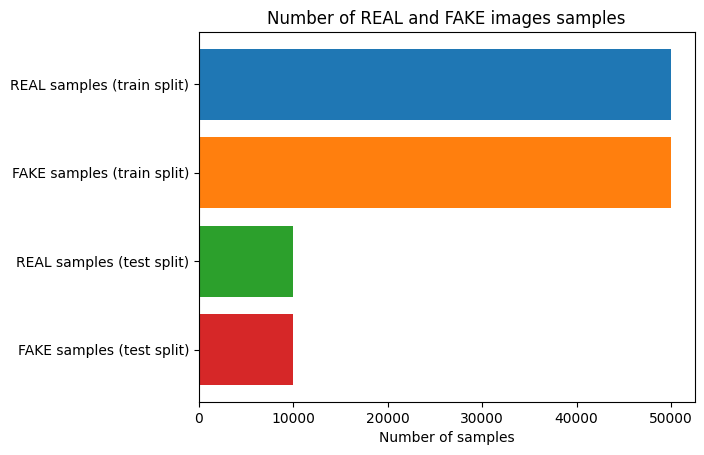

In [11]:
fig = plt.figure()
plt.barh(0, width=len(samples_list_train_real))
plt.barh(1, width=len(samples_list_train_fake))
plt.barh(2, width=len(samples_list_test_real))
plt.barh(3, width=len(samples_list_test_fake))
plt.gca().invert_yaxis()
plt.yticks([0, 1, 2, 3], ['REAL samples (train split)', 'FAKE samples (train split)', 'REAL samples (test split)', 'FAKE samples (test split)'])
plt.xlabel('Number of samples')
plt.title('Number of REAL and FAKE images samples')
plt.show()

## Display a few random samples

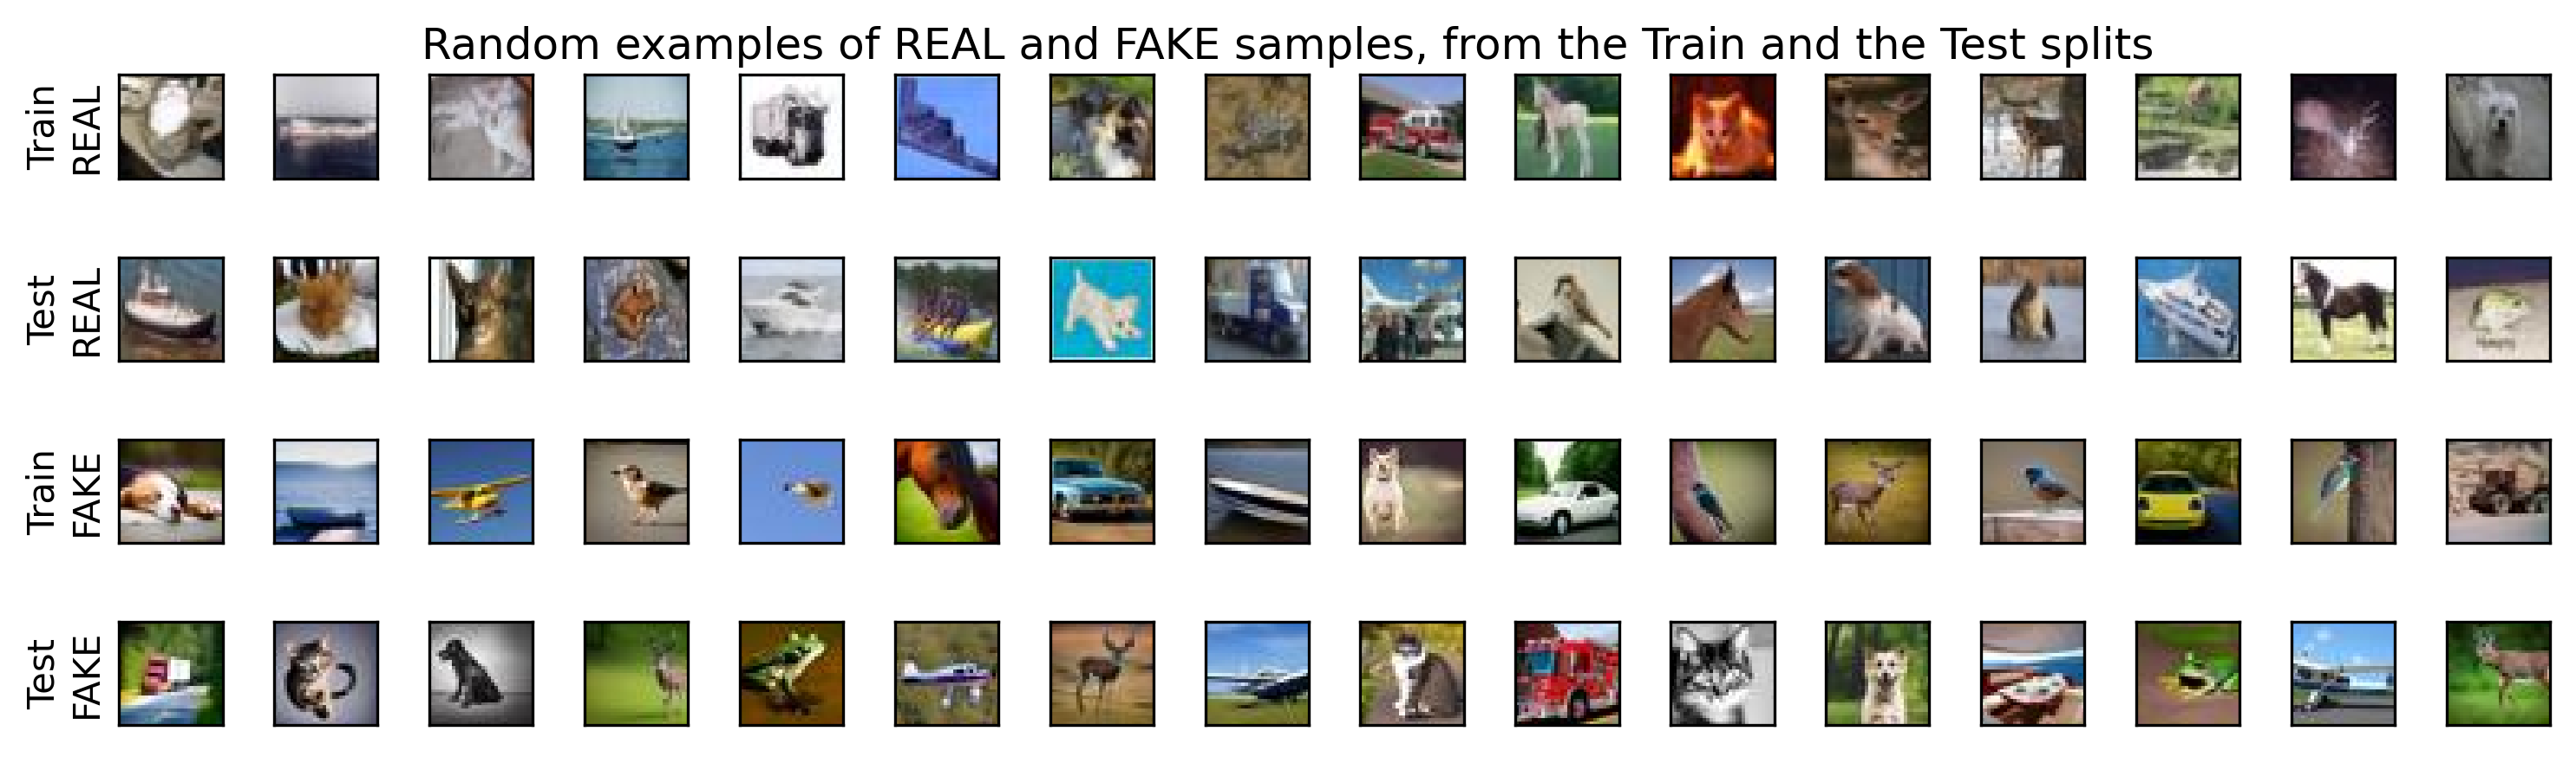

In [12]:
number_of_displayed_samples = 16

fig, ax = plt.subplots(4, number_of_displayed_samples)
fig.set_dpi(300)
fig.set_size_inches(10, 3, forward=True)

for index in range(number_of_displayed_samples):

    axx = ax[0, index]
    fig.sca(axx)
    plt.imshow(img.imread(os.path.join(path_dataset_train_real, samples_list_train_real[index])))
    plt.ylabel('Train\nREAL') if index==0 else None

    axx = ax[1, index]
    fig.sca(axx)
    plt.imshow(img.imread(os.path.join(path_dataset_test_real, samples_list_test_real[index])))
    plt.ylabel('Test\nREAL') if index==0 else None

    axx = ax[2, index]
    fig.sca(axx)
    plt.imshow(img.imread(os.path.join(path_dataset_train_fake, samples_list_train_fake[index])))
    plt.ylabel('Train\nFAKE') if index==0 else None

    axx = ax[3, index]
    fig.sca(axx)
    plt.imshow(img.imread(os.path.join(path_dataset_test_fake, samples_list_test_fake[index])))
    plt.ylabel('Test\nFAKE') if index==0 else None

[axx.set_xticks([]) for axx in ax.ravel()]
[axx.set_yticks([]) for axx in ax.ravel()]
plt.tight_layout()
plt.suptitle('Random examples of REAL and FAKE samples, from the Train and the Test splits')
plt.show()

# Helper functions 

In [13]:
def plot_metrics(model_history, test_loss, test_recall, test_accuracy, test_precision, number_of_epochs):
    fig, ax = plt.subplots(2, 2)
    fig.set_dpi(300)
    fig.set_size_inches(12, 12, forward=True)

    metric_name = 'loss'
    axx = ax[0, 0]
    fig.sca(axx)
    plt.plot(model_history.history['{}'.format(metric_name)], label='{}'.format(metric_name))
    plt.plot(model_history.history['val_{}'.format(metric_name)], label='val_{}'.format(metric_name))
    plt.scatter(number_of_epochs -1, test_loss, color='darkgreen', label='test_{}'.format(metric_name))
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

    metric_name = 'recall'
    axx = ax[0, 1]
    fig.sca(axx)
    plt.plot(model_history.history['{}'.format(metric_name)], label='{}'.format(metric_name))
    plt.plot(model_history.history['val_{}'.format(metric_name)], label='val_{}'.format(metric_name))
    plt.scatter(number_of_epochs -1, test_recall, color='darkgreen', label='test_{}'.format(metric_name))
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

    metric_name = 'accuracy'
    axx = ax[1, 0]
    fig.sca(axx)
    plt.plot(model_history.history['{}'.format(metric_name)], label='{}'.format(metric_name))
    plt.plot(model_history.history['val_{}'.format(metric_name)], label='val_{}'.format(metric_name))
    plt.scatter(number_of_epochs -1, test_accuracy, color='darkgreen', label='test_{}'.format(metric_name))    
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    
    metric_name = 'precision'
    axx = ax[1, 1]
    fig.sca(axx)
    plt.plot(model_history.history['{}'.format(metric_name)], label='{}'.format(metric_name))
    plt.plot(model_history.history['val_{}'.format(metric_name)], label='val_{}'.format(metric_name))
    plt.scatter(number_of_epochs -1, test_precision, color='darkgreen', label='test_{}'.format(metric_name))    
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [14]:
def evaluate_model(model, dataloader, split_name):
    loss, accuracy, precision, recall = model.evaluate(dataloader)
    print('Dataset: {}'.format(split_name))
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    return loss, accuracy, precision, recall

In [15]:
def get_predictions_and_labels(dataloader, model):
    predicted_values = np.array([])
    predicted_classes = np.array([])
    labels = np.array([])    
    for x, y in dataloader:        
        predicted_values = np.concatenate([predicted_values, model(x)[:,0]])
        predicted_classes = np.concatenate([predicted_classes, [0 if pred < 0.5 else 1 for pred in model(x)]])
        labels = np.concatenate([labels, y])
    return predicted_values, predicted_classes, labels

In [16]:
def plot_confusion_matrix(labels, predicted_classes, class_names):
    cm = confusion_matrix(labels, predicted_classes)
    plt.figure()
    fig.set_dpi(300)
    fig.set_size_inches(12, 12, forward=True)
    sns.heatmap(cm/np.sum(cm), annot=True, cmap='Blues',fmt='.2%', square=True, xticklabels=class_names, yticklabels=class_names, vmin=0, vmax=1)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

In [17]:
def plot_roc_curve(labels, predicted_values):
    fpr, tpr, thresholds = roc_curve(labels, predicted_values)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    fig.set_dpi(300)
    fig.set_size_inches(12, 12, forward=True)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC AUC = {:.3f})'.format(roc_auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.tight_layout()    
    plt.gca().set_aspect('equal')
    plt.show()

In [18]:
def plot_predicted_values_per_class(predicted_values, labels):
    plt.figure()
    fig.set_dpi(300)
    fig.set_size_inches(12, 12, forward=True)
    plt.plot(np.sort(predicted_values[labels==1]), label='Real images')
    plt.plot(np.flip(np.sort(predicted_values[labels==0])), label='Fake images')
    plt.xlabel('Samples (sorted)')
    plt.ylabel('Predicted values')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [19]:
def plot_extreme_predictions(predicted_values, labels):

    indices_of_real_images = np.where(labels==1)
    indices_of_fake_images = np.where(labels==0)

    predicted_value_for_real_images = predicted_values[labels==1]
    predicted_value_for_fake_images = predicted_values[labels==0]

    indices_of_real_images_sorted_from_worst_to_best_prediction = np.argsort(predicted_value_for_real_images)
    indices_of_fake_images_sorted_from_worst_to_best_prediction = np.flip(np.argsort(predicted_value_for_fake_images))
    
    # Display a few images
    number_of_displayed_samples = 16
    
    fig, ax = plt.subplots(4, number_of_displayed_samples)
    fig.set_dpi(300)
    fig.set_size_inches(10, 3, forward=True)
    
    for i in range(number_of_displayed_samples):
    
        axx = ax[0, i]
        fig.sca(axx)
        index = indices_of_real_images_sorted_from_worst_to_best_prediction[i]
        plt.imshow(img.imread(os.path.join(path_dataset_train_real, samples_list_train_real[index])))
        plt.ylabel('REAL\n(failures)') if i==0 else None
    
        axx = ax[1, i]
        fig.sca(axx)
        index = indices_of_real_images_sorted_from_worst_to_best_prediction[9999-i]        
        plt.imshow(img.imread(os.path.join(path_dataset_test_real, samples_list_test_real[index])))
        plt.ylabel('REAL\n(success)') if i==0 else None
    
        axx = ax[2, i]
        fig.sca(axx)
        index = indices_of_fake_images_sorted_from_worst_to_best_prediction[i]        
        plt.imshow(img.imread(os.path.join(path_dataset_train_fake, samples_list_train_fake[index])))
        plt.ylabel('FAKE\n(failures)') if i==0 else None
    
        axx = ax[3, i]
        fig.sca(axx)
        index = indices_of_fake_images_sorted_from_worst_to_best_prediction[9999-i]             
        plt.imshow(img.imread(os.path.join(path_dataset_test_fake, samples_list_test_fake[index])))
        plt.ylabel('FAKE\n(success)') if i==0 else None    
    
    [axx.set_xticks([]) for axx in ax.ravel()]
    [axx.set_yticks([]) for axx in ax.ravel()]
    plt.tight_layout()    
    plt.suptitle('Correctly (\'success\') and incorrectly (\'failures\') classified images')
    plt.show()

# Model 0 | Random predictions | ROC AUC 0.492

In [20]:
# Generate random predictions
labels = np.array([])
for x, y in test_set_dataloader:
    labels = np.concatenate([labels, y])
    
predicted_values = np.random.rand(len(labels),)
predicted_values -= np.min(predicted_values)
predicted_values /= np.max(predicted_values)
predicted_classes = (predicted_values > 0.5).astype(np.int32)

2024-09-05 15:59:42.401189: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


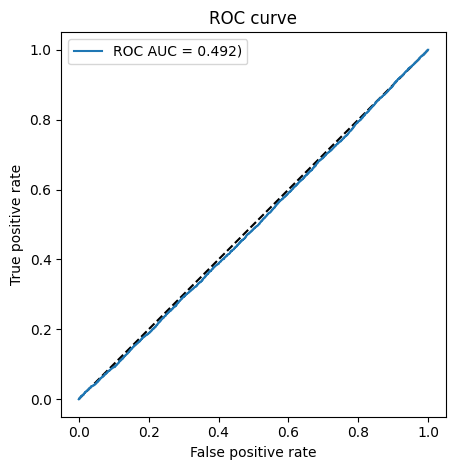

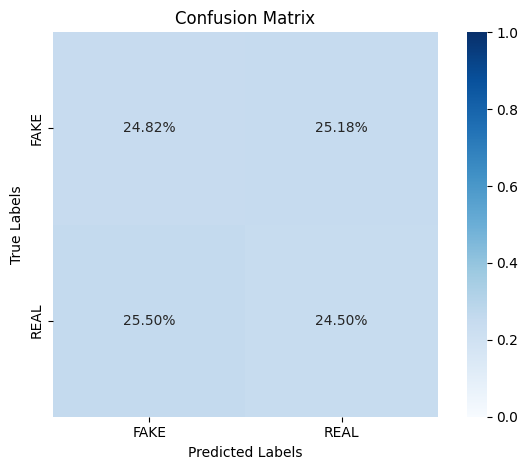

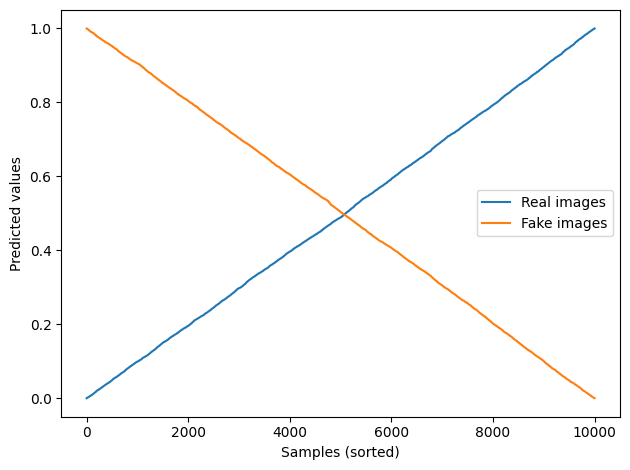

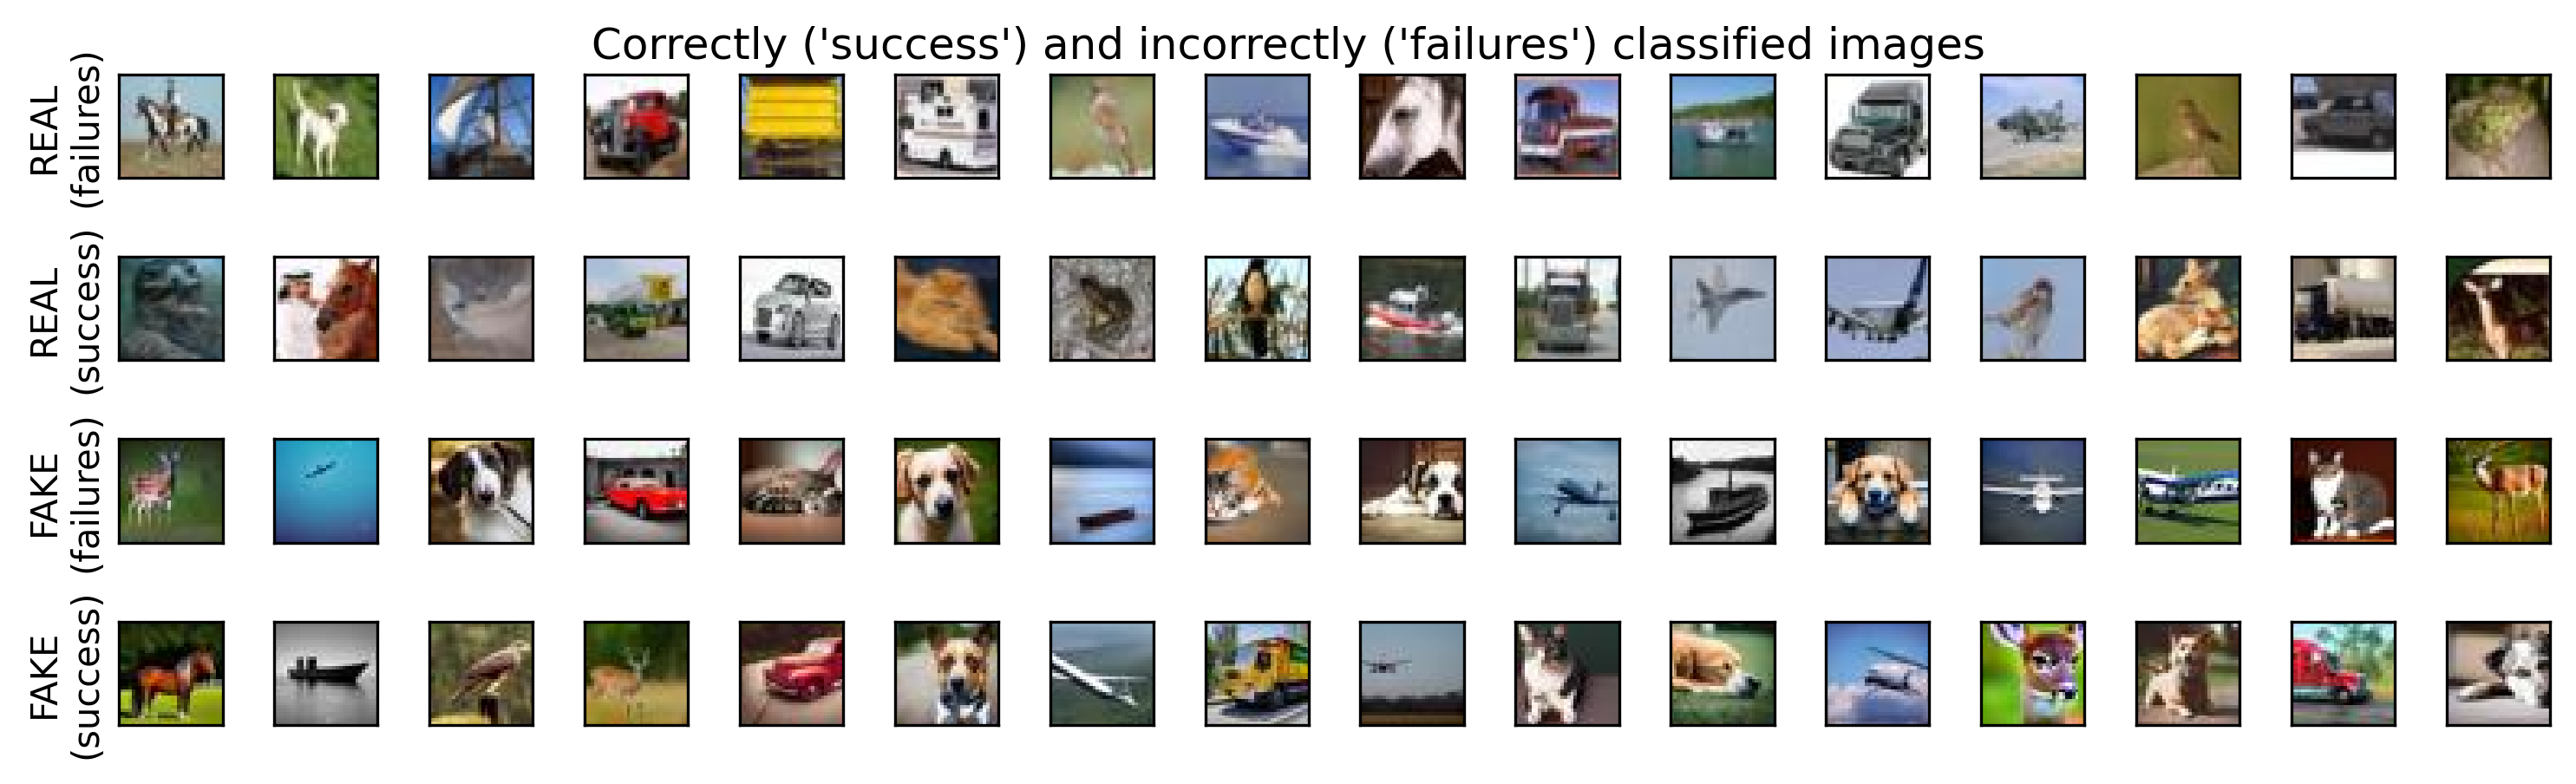

In [21]:
# Plot results
plot_roc_curve(labels, predicted_values)
plot_confusion_matrix(labels, predicted_classes, test_set_dataloader.class_names)
plot_predicted_values_per_class(predicted_values, labels)
plot_extreme_predictions(predicted_values, labels)

# Model 1 | Fully-convolutional | 2.3k parameters | ROC AUC 0.951

In [22]:
# Design the model
model = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed=random_seed),
    tf.keras.layers.Resizing(image_height, image_width),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),    
    tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='sigmoid')])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')])

# Build the model and show the summary
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,305 (9.00 KB)

 Trainable params: 2,289 (8.94 KB)

 Non-trainable params: 16 (64.00 B)

In [23]:
# Train the model
number_of_epochs = 50
history = model.fit(
    train_set_dataloader, validation_data=validation_set_dataloader, epochs=number_of_epochs, verbose=2)

Epoch 1/50


I0000 00:00:1725544785.216434  129029 service.cc:146] XLA service 0x7cc89c003850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725544785.216571  129029 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2024-09-05 15:59:45.248124: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-05 15:59:45.369798: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
I0000 00:00:1725544786.605715  129029 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 - 6s - 18ms/step - accuracy: 0.7325 - loss: 0.5317 - precision: 0.7488 - recall: 0.6970 - val_accuracy: 0.6115 - val_loss: 0.6932 - val_precision: 0.5625 - val_recall: 0.9892
Epoch 2/50
313/313 - 1s - 3ms/step - accuracy: 0.8046 - loss: 0.4261 - precision: 0.7971 - recall: 0.8156 - val_accuracy: 0.7730 - val_loss: 0.4868 - val_precision: 0.7073 - val_recall: 0.9280
Epoch 3/50
313/313 - 1s - 3ms/step - accuracy: 0.8195 - loss: 0.4030 - precision: 0.8104 - recall: 0.8327 - val_accuracy: 0.8159 - val_loss: 0.4049 - val_precision: 0.7797 - val_recall: 0.8784
Epoch 4/50
313/313 - 1s - 3ms/step - accuracy: 0.8281 - loss: 0.3852 - precision: 0.8187 - recall: 0.8416 - val_accuracy: 0.8180 - val_loss: 0.4052 - val_precision: 0.7894 - val_recall: 0.8651
Epoch 5/50
313/313 - 1s - 3ms/step - accuracy: 0.8342 - loss: 0.3720 - precision: 0.8252 - recall: 0.8467 - val_accuracy: 0.8173 - val_loss: 0.4080 - val_precision: 0.7650 - val_recall: 0.9137
Epoch 6/50
313/313 - 1s - 2ms/step - accuracy

In [24]:
# Infer the model
evaluate_model(model, validation_set_dataloader, 'Validation')
test_loss, test_accuracy, test_precision, test_recall = evaluate_model(model, test_set_dataloader, 'Test')
predicted_values, predicted_classes, labels = get_predictions_and_labels(test_set_dataloader, model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8796 - loss: 0.2975 - precision: 0.8880 - recall: 0.8633
Dataset: Validation
Loss: 0.3020
Accuracy: 0.8813
Precision: 0.8939
Recall: 0.8641
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8857 - loss: 0.2879 - precision: 0.8974 - recall: 0.8690
Dataset: Test
Loss: 0.2962
Accuracy: 0.8835
Precision: 0.8964
Recall: 0.8673


W0000 00:00:1725544828.569557  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725544828.595285  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725544828.595964  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725544828.596645  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725544828.598909  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725544828.599582  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725544828.603105  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725544828.603801  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725544828.604501  128853 gp

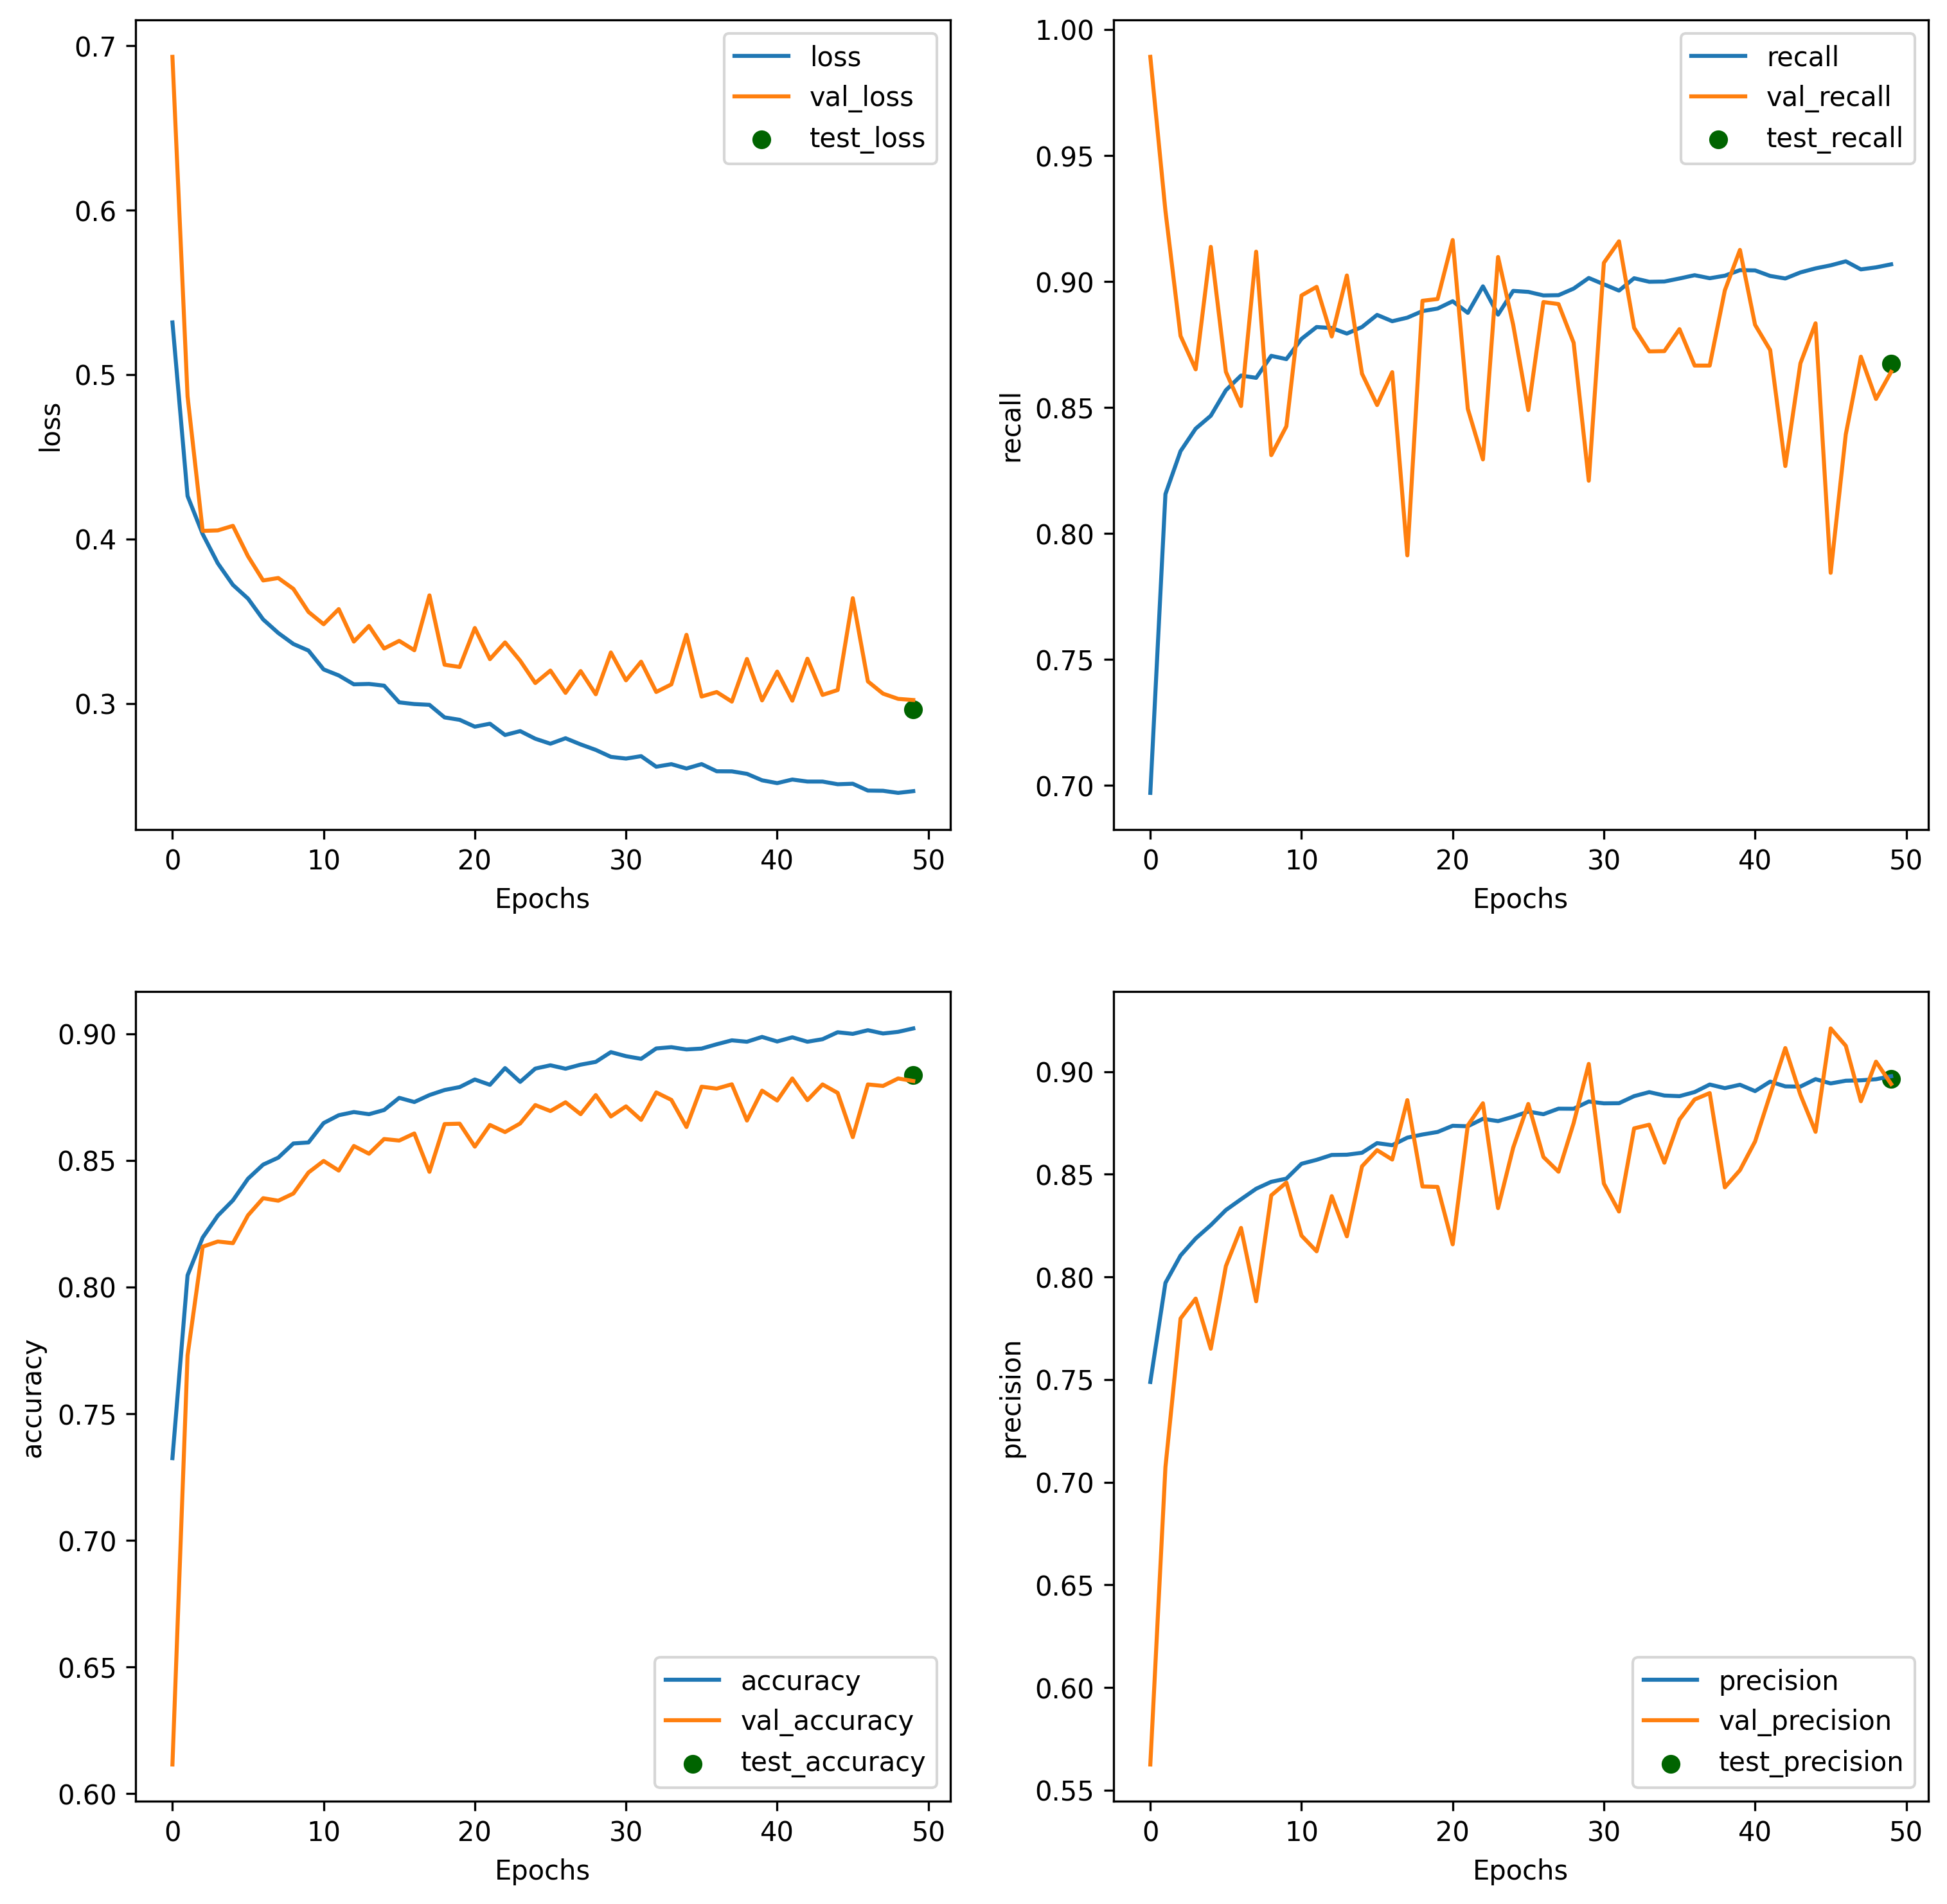

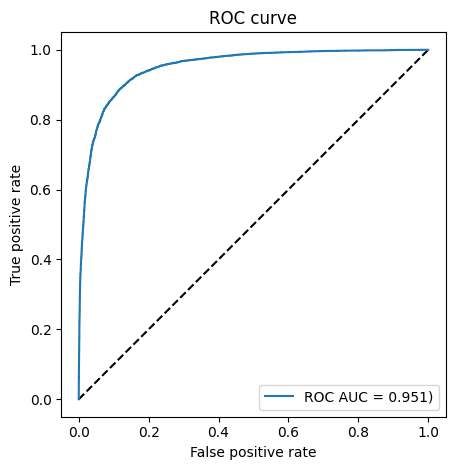

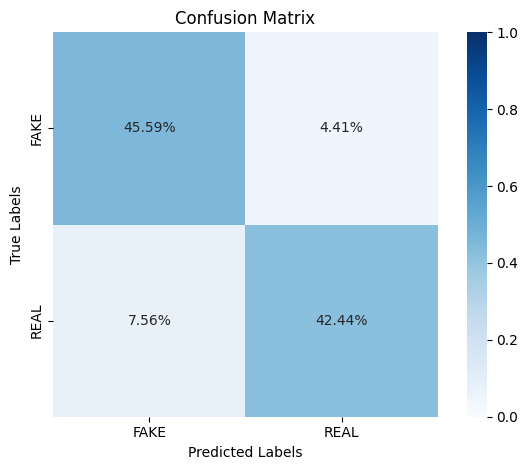

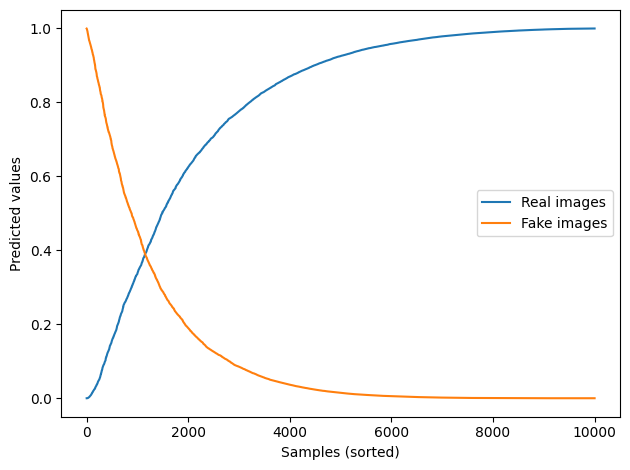

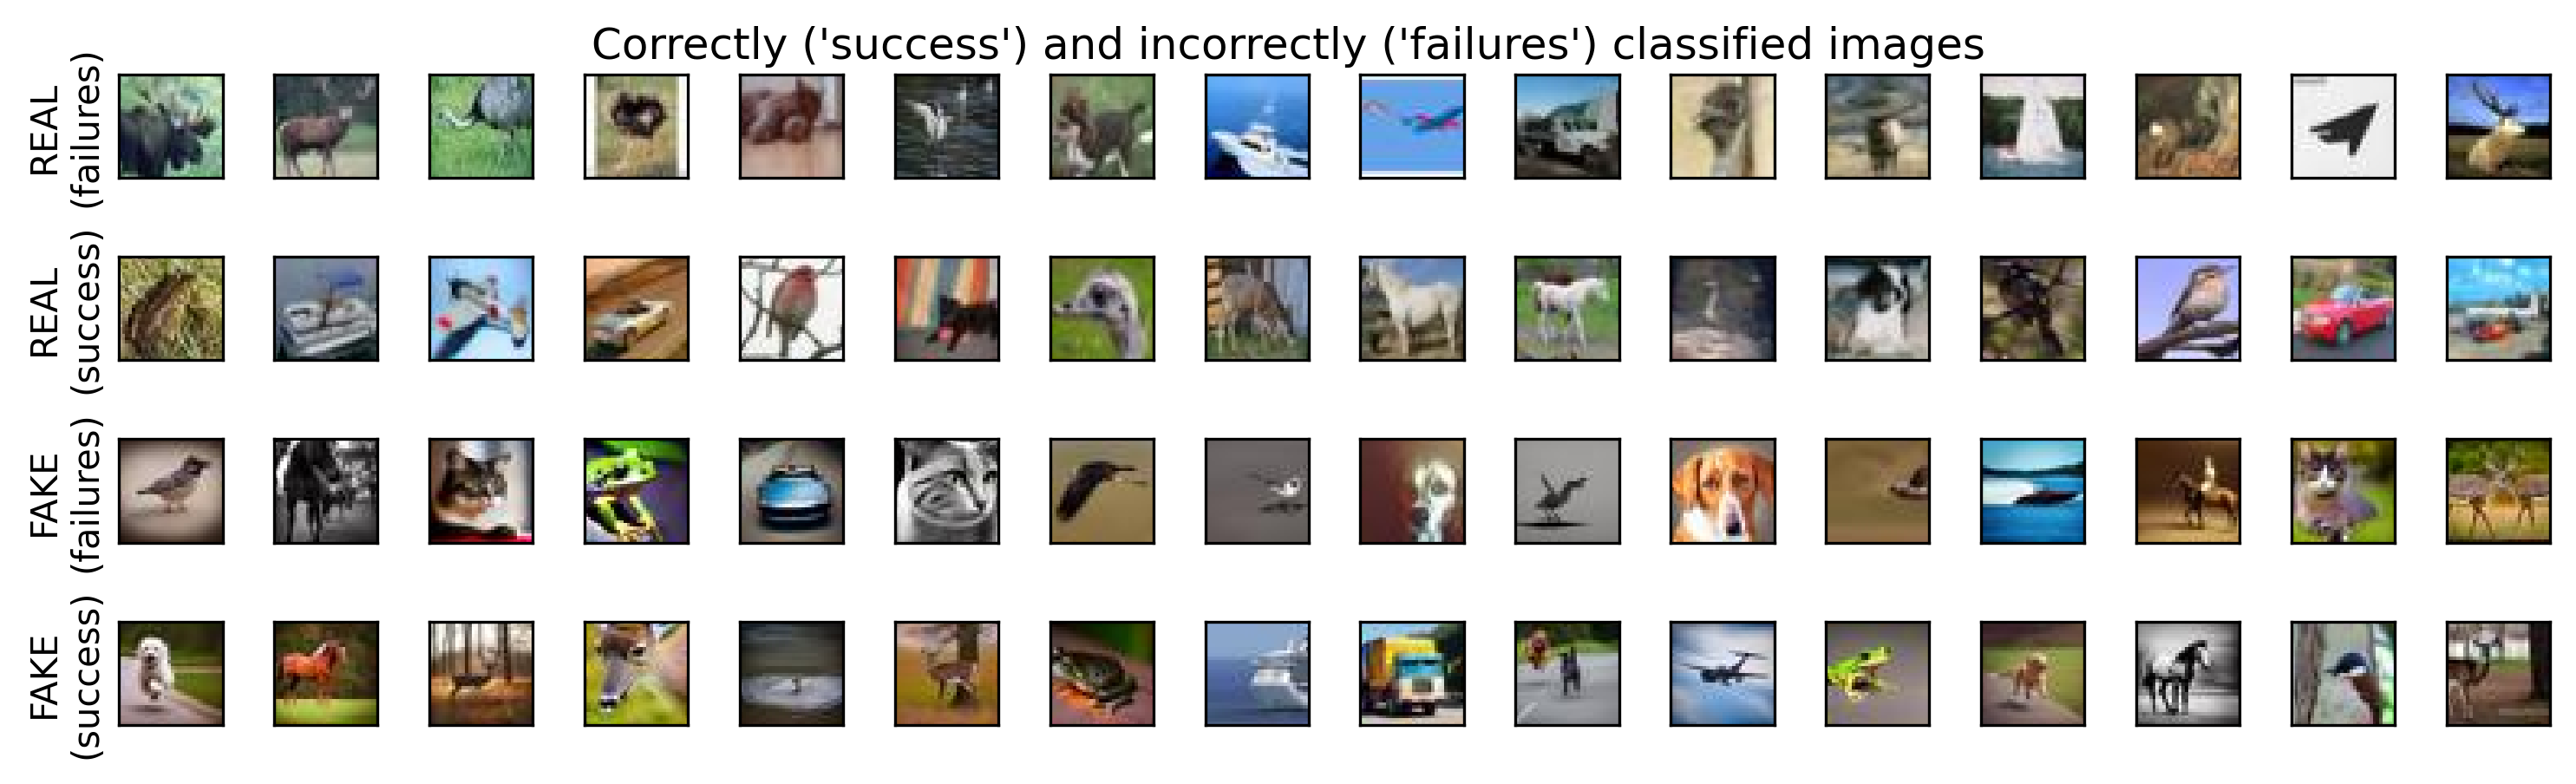

In [25]:
# Plot results
plot_metrics(history, test_loss, test_recall, test_accuracy, test_precision, number_of_epochs)
plot_roc_curve(labels, predicted_values)
plot_confusion_matrix(labels, predicted_classes, test_set_dataloader.class_names)
plot_predicted_values_per_class(predicted_values, labels)
plot_extreme_predictions(predicted_values, labels)

# Model 2 | Fully-convolutional | 1.2M parameters | ROC AUC 0.988

In [26]:
# Design the model
model = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed=random_seed),
    tf.keras.layers.Resizing(image_height, image_width),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),    
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5), # Random dropout to prevent overfitting
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.5), # Random dropout to prevent overfitting
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.5), # Random dropout to prevent overfitting
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.5), # Random dropout to prevent overfitting
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.5), # Random dropout to prevent overfitting
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='sigmoid')])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')])

# Build the model and show the summary
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 1,153,089 (4.40 MB)

 Trainable params: 1,151,297 (4.39 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [27]:
# Train the model
number_of_epochs = 50
history = model.fit(
    train_set_dataloader, validation_data=validation_set_dataloader, epochs=number_of_epochs, verbose=2)

Epoch 1/50
313/313 - 21s - 68ms/step - accuracy: 0.7711 - loss: 0.5396 - precision: 0.7637 - recall: 0.7830 - val_accuracy: 0.4787 - val_loss: 0.8349 - val_precision: 0.4552 - val_recall: 0.2395
Epoch 2/50
313/313 - 5s - 14ms/step - accuracy: 0.8666 - loss: 0.3235 - precision: 0.8617 - recall: 0.8723 - val_accuracy: 0.5697 - val_loss: 1.3675 - val_precision: 0.5366 - val_recall: 0.9954
Epoch 3/50
313/313 - 5s - 15ms/step - accuracy: 0.8909 - loss: 0.2692 - precision: 0.8869 - recall: 0.8953 - val_accuracy: 0.7279 - val_loss: 0.6740 - val_precision: 0.6500 - val_recall: 0.9827
Epoch 4/50
313/313 - 5s - 15ms/step - accuracy: 0.9034 - loss: 0.2468 - precision: 0.9000 - recall: 0.9069 - val_accuracy: 0.7627 - val_loss: 0.6066 - val_precision: 0.6821 - val_recall: 0.9801
Epoch 5/50
313/313 - 5s - 15ms/step - accuracy: 0.9079 - loss: 0.2336 - precision: 0.9035 - recall: 0.9125 - val_accuracy: 0.8077 - val_loss: 0.5162 - val_precision: 0.7256 - val_recall: 0.9867
Epoch 6/50
313/313 - 5s - 16m

In [28]:
# Infer the model
evaluate_model(model, validation_set_dataloader, 'Validation')
test_loss, test_accuracy, test_precision, test_recall = evaluate_model(model, test_set_dataloader, 'Test')
predicted_values, predicted_classes, labels = get_predictions_and_labels(test_set_dataloader, model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9257 - loss: 0.2167 - precision: 0.8860 - recall: 0.9747
Dataset: Validation
Loss: 0.2195
Accuracy: 0.9266
Precision: 0.8901
Recall: 0.9728
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9317 - loss: 0.1978 - precision: 0.8957 - recall: 0.9762
Dataset: Test
Loss: 0.2116
Accuracy: 0.9283
Precision: 0.8923
Recall: 0.9742


W0000 00:00:1725545102.854584  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725545102.855277  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725545102.855916  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725545102.856557  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725545102.857205  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725545102.857857  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725545102.858560  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725545102.859314  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725545102.861083  128853 gp

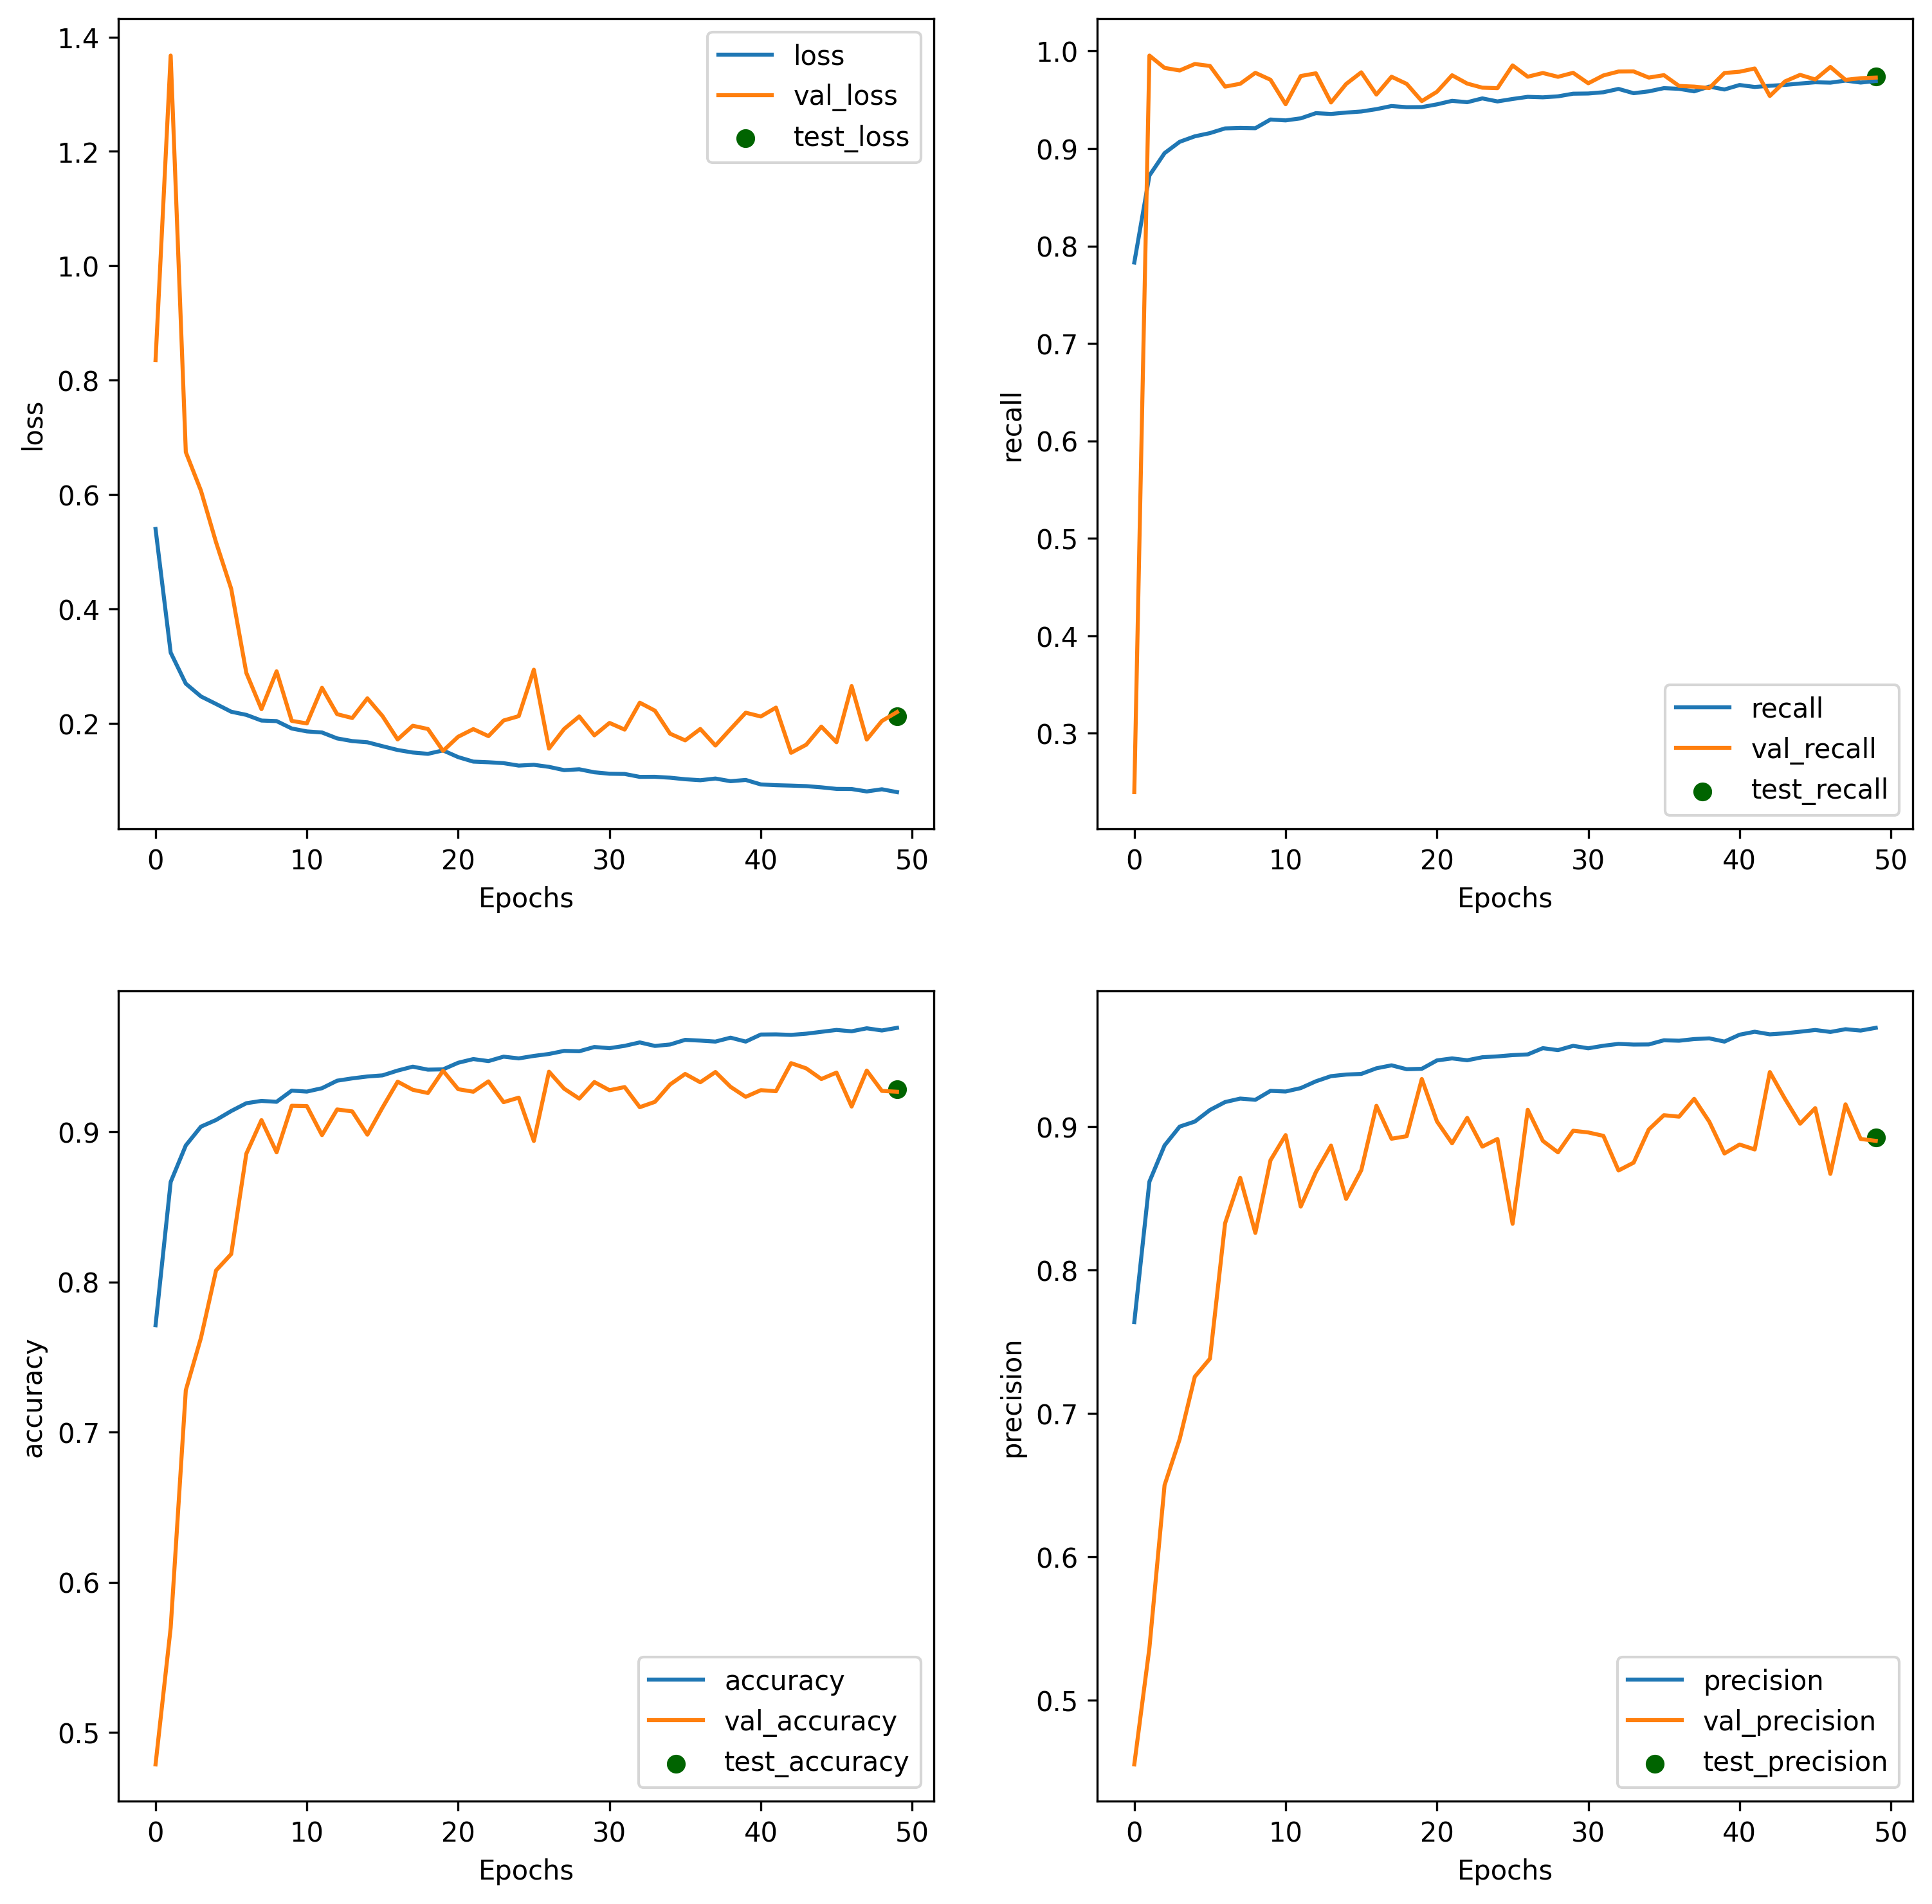

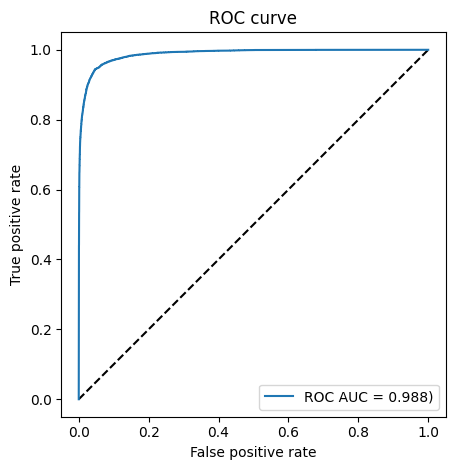

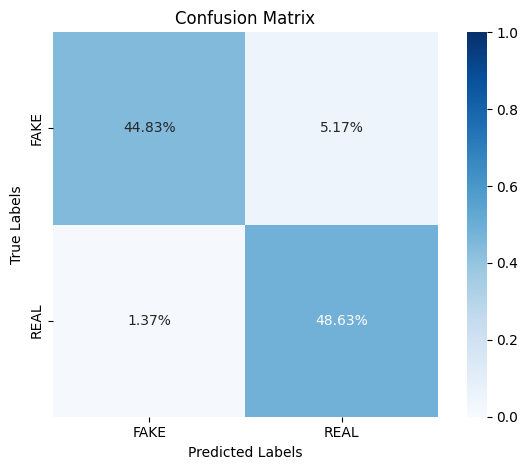

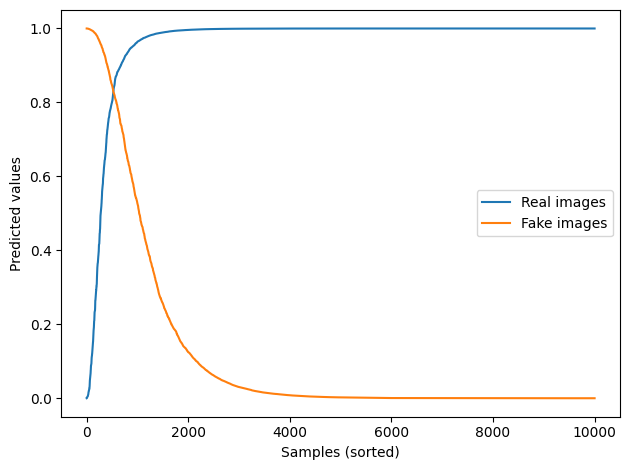

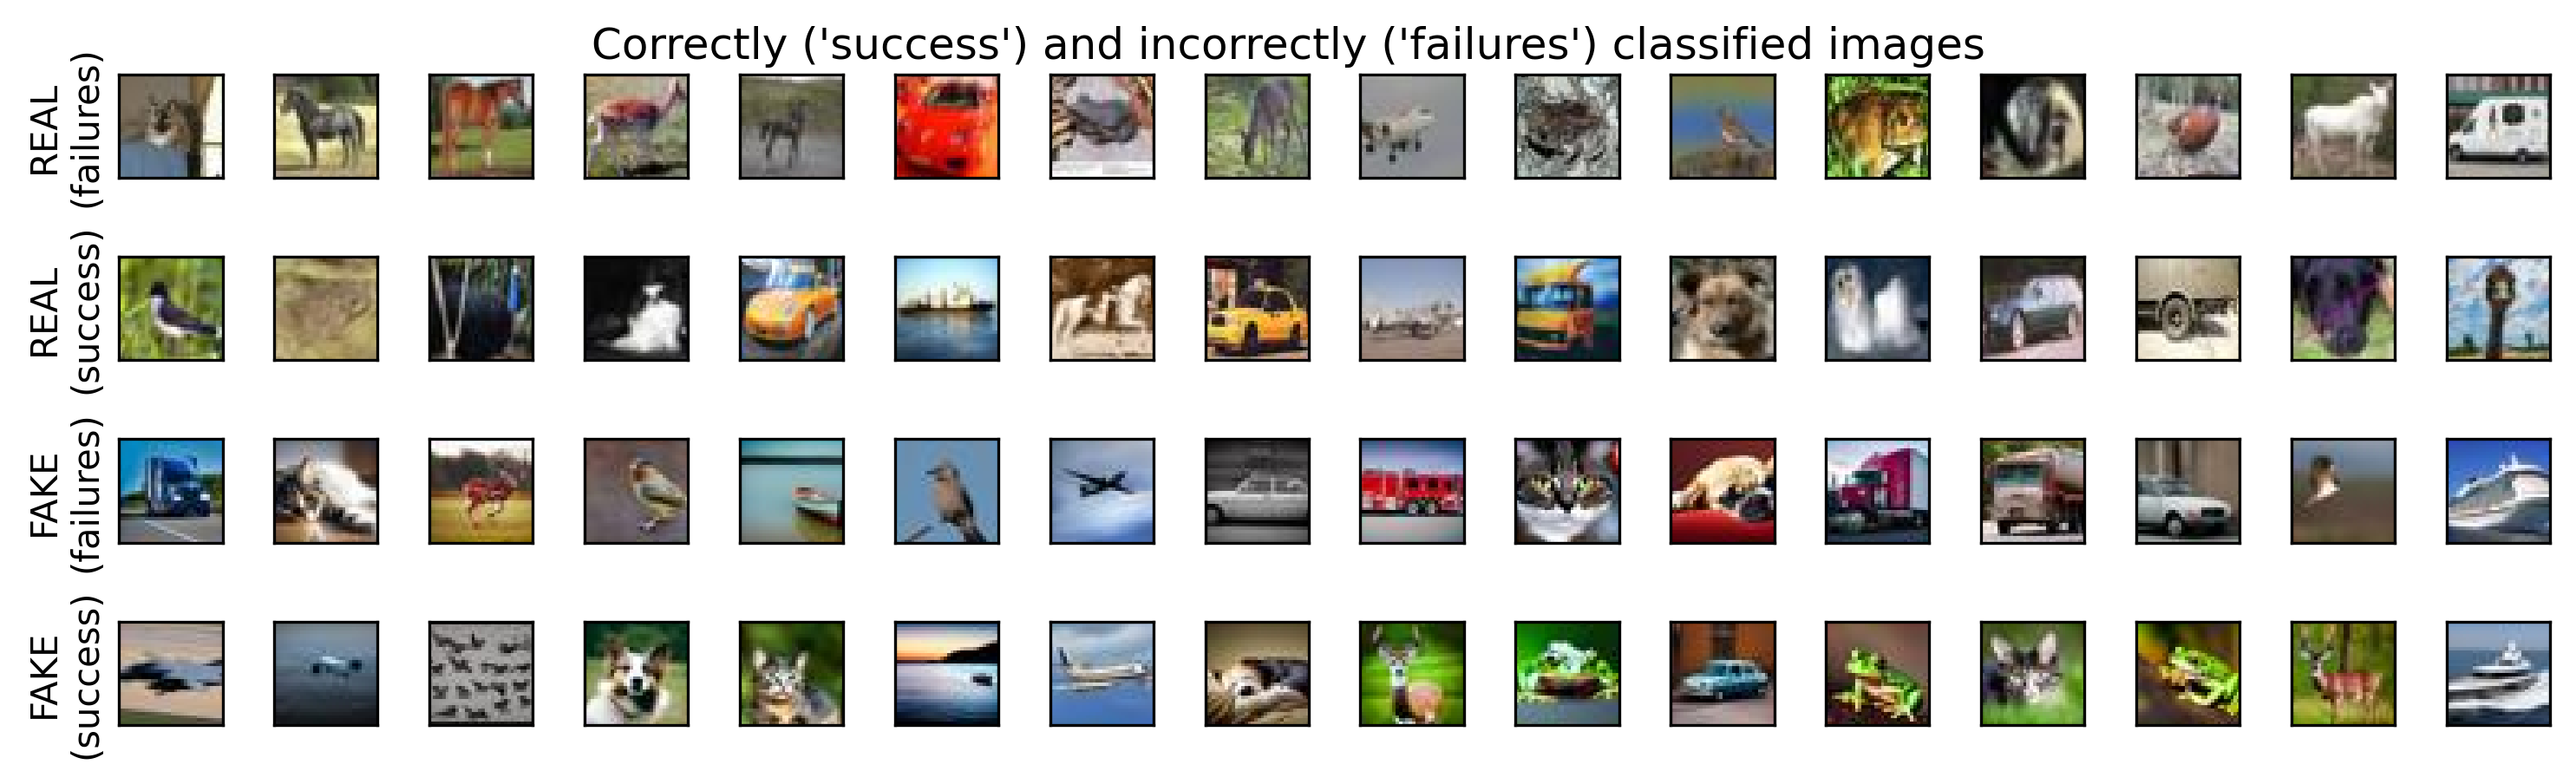

In [29]:
# Plot results
plot_metrics(history, test_loss, test_recall, test_accuracy, test_precision, number_of_epochs)
plot_roc_curve(labels, predicted_values)
plot_confusion_matrix(labels, predicted_classes, test_set_dataloader.class_names)
plot_predicted_values_per_class(predicted_values, labels)
plot_extreme_predictions(predicted_values, labels)

# Model 3 | Mostly dense connections | 2.1M parameters | ROC AUC 0.972

In [30]:
# Design the model
model = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed=random_seed),
    tf.keras.layers.Resizing(image_height, image_width),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),    
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),    
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5), # Random dropout to prevent overfitting
    tf.keras.layers.Dense(units=1, activation='sigmoid')])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')])

# Build the model and show the summary
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_2 (Resizing)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,099,457 (8.01 MB)

 Trainable params: 2,099,329 (8.01 MB)

 Non-trainable params: 128 (512.00 B)

In [31]:
# Train the model
number_of_epochs = 50
history = model.fit(
    train_set_dataloader, validation_data=validation_set_dataloader, epochs=number_of_epochs, verbose=2)

Epoch 1/50
313/313 - 7s - 21ms/step - accuracy: 0.7426 - loss: 0.5282 - precision: 0.7465 - recall: 0.7322 - val_accuracy: 0.7177 - val_loss: 0.5984 - val_precision: 0.6525 - val_recall: 0.9265
Epoch 2/50
313/313 - 1s - 4ms/step - accuracy: 0.8120 - loss: 0.4184 - precision: 0.8100 - recall: 0.8137 - val_accuracy: 0.7883 - val_loss: 0.4624 - val_precision: 0.7174 - val_recall: 0.9486
Epoch 3/50
313/313 - 1s - 4ms/step - accuracy: 0.8255 - loss: 0.3886 - precision: 0.8238 - recall: 0.8265 - val_accuracy: 0.8354 - val_loss: 0.3745 - val_precision: 0.7852 - val_recall: 0.9215
Epoch 4/50
313/313 - 1s - 4ms/step - accuracy: 0.8387 - loss: 0.3675 - precision: 0.8361 - recall: 0.8413 - val_accuracy: 0.8529 - val_loss: 0.3440 - val_precision: 0.8324 - val_recall: 0.8821
Epoch 5/50
313/313 - 1s - 4ms/step - accuracy: 0.8530 - loss: 0.3466 - precision: 0.8490 - recall: 0.8575 - val_accuracy: 0.8203 - val_loss: 0.4028 - val_precision: 0.7469 - val_recall: 0.9666
Epoch 6/50
313/313 - 1s - 4ms/step

In [32]:
# Infer the model
evaluate_model(model, validation_set_dataloader, 'Validation')
test_loss, test_accuracy, test_precision, test_recall = evaluate_model(model, test_set_dataloader, 'Test')
predicted_values, predicted_classes, labels = get_predictions_and_labels(test_set_dataloader, model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9108 - loss: 0.2219 - precision: 0.8956 - recall: 0.9268
Dataset: Validation
Loss: 0.2245
Accuracy: 0.9097
Precision: 0.8971
Recall: 0.9248
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9134 - loss: 0.2179 - precision: 0.8980 - recall: 0.9317
Dataset: Test
Loss: 0.2215
Accuracy: 0.9130
Precision: 0.8987
Recall: 0.9309


2024-09-05 16:06:39.069358: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


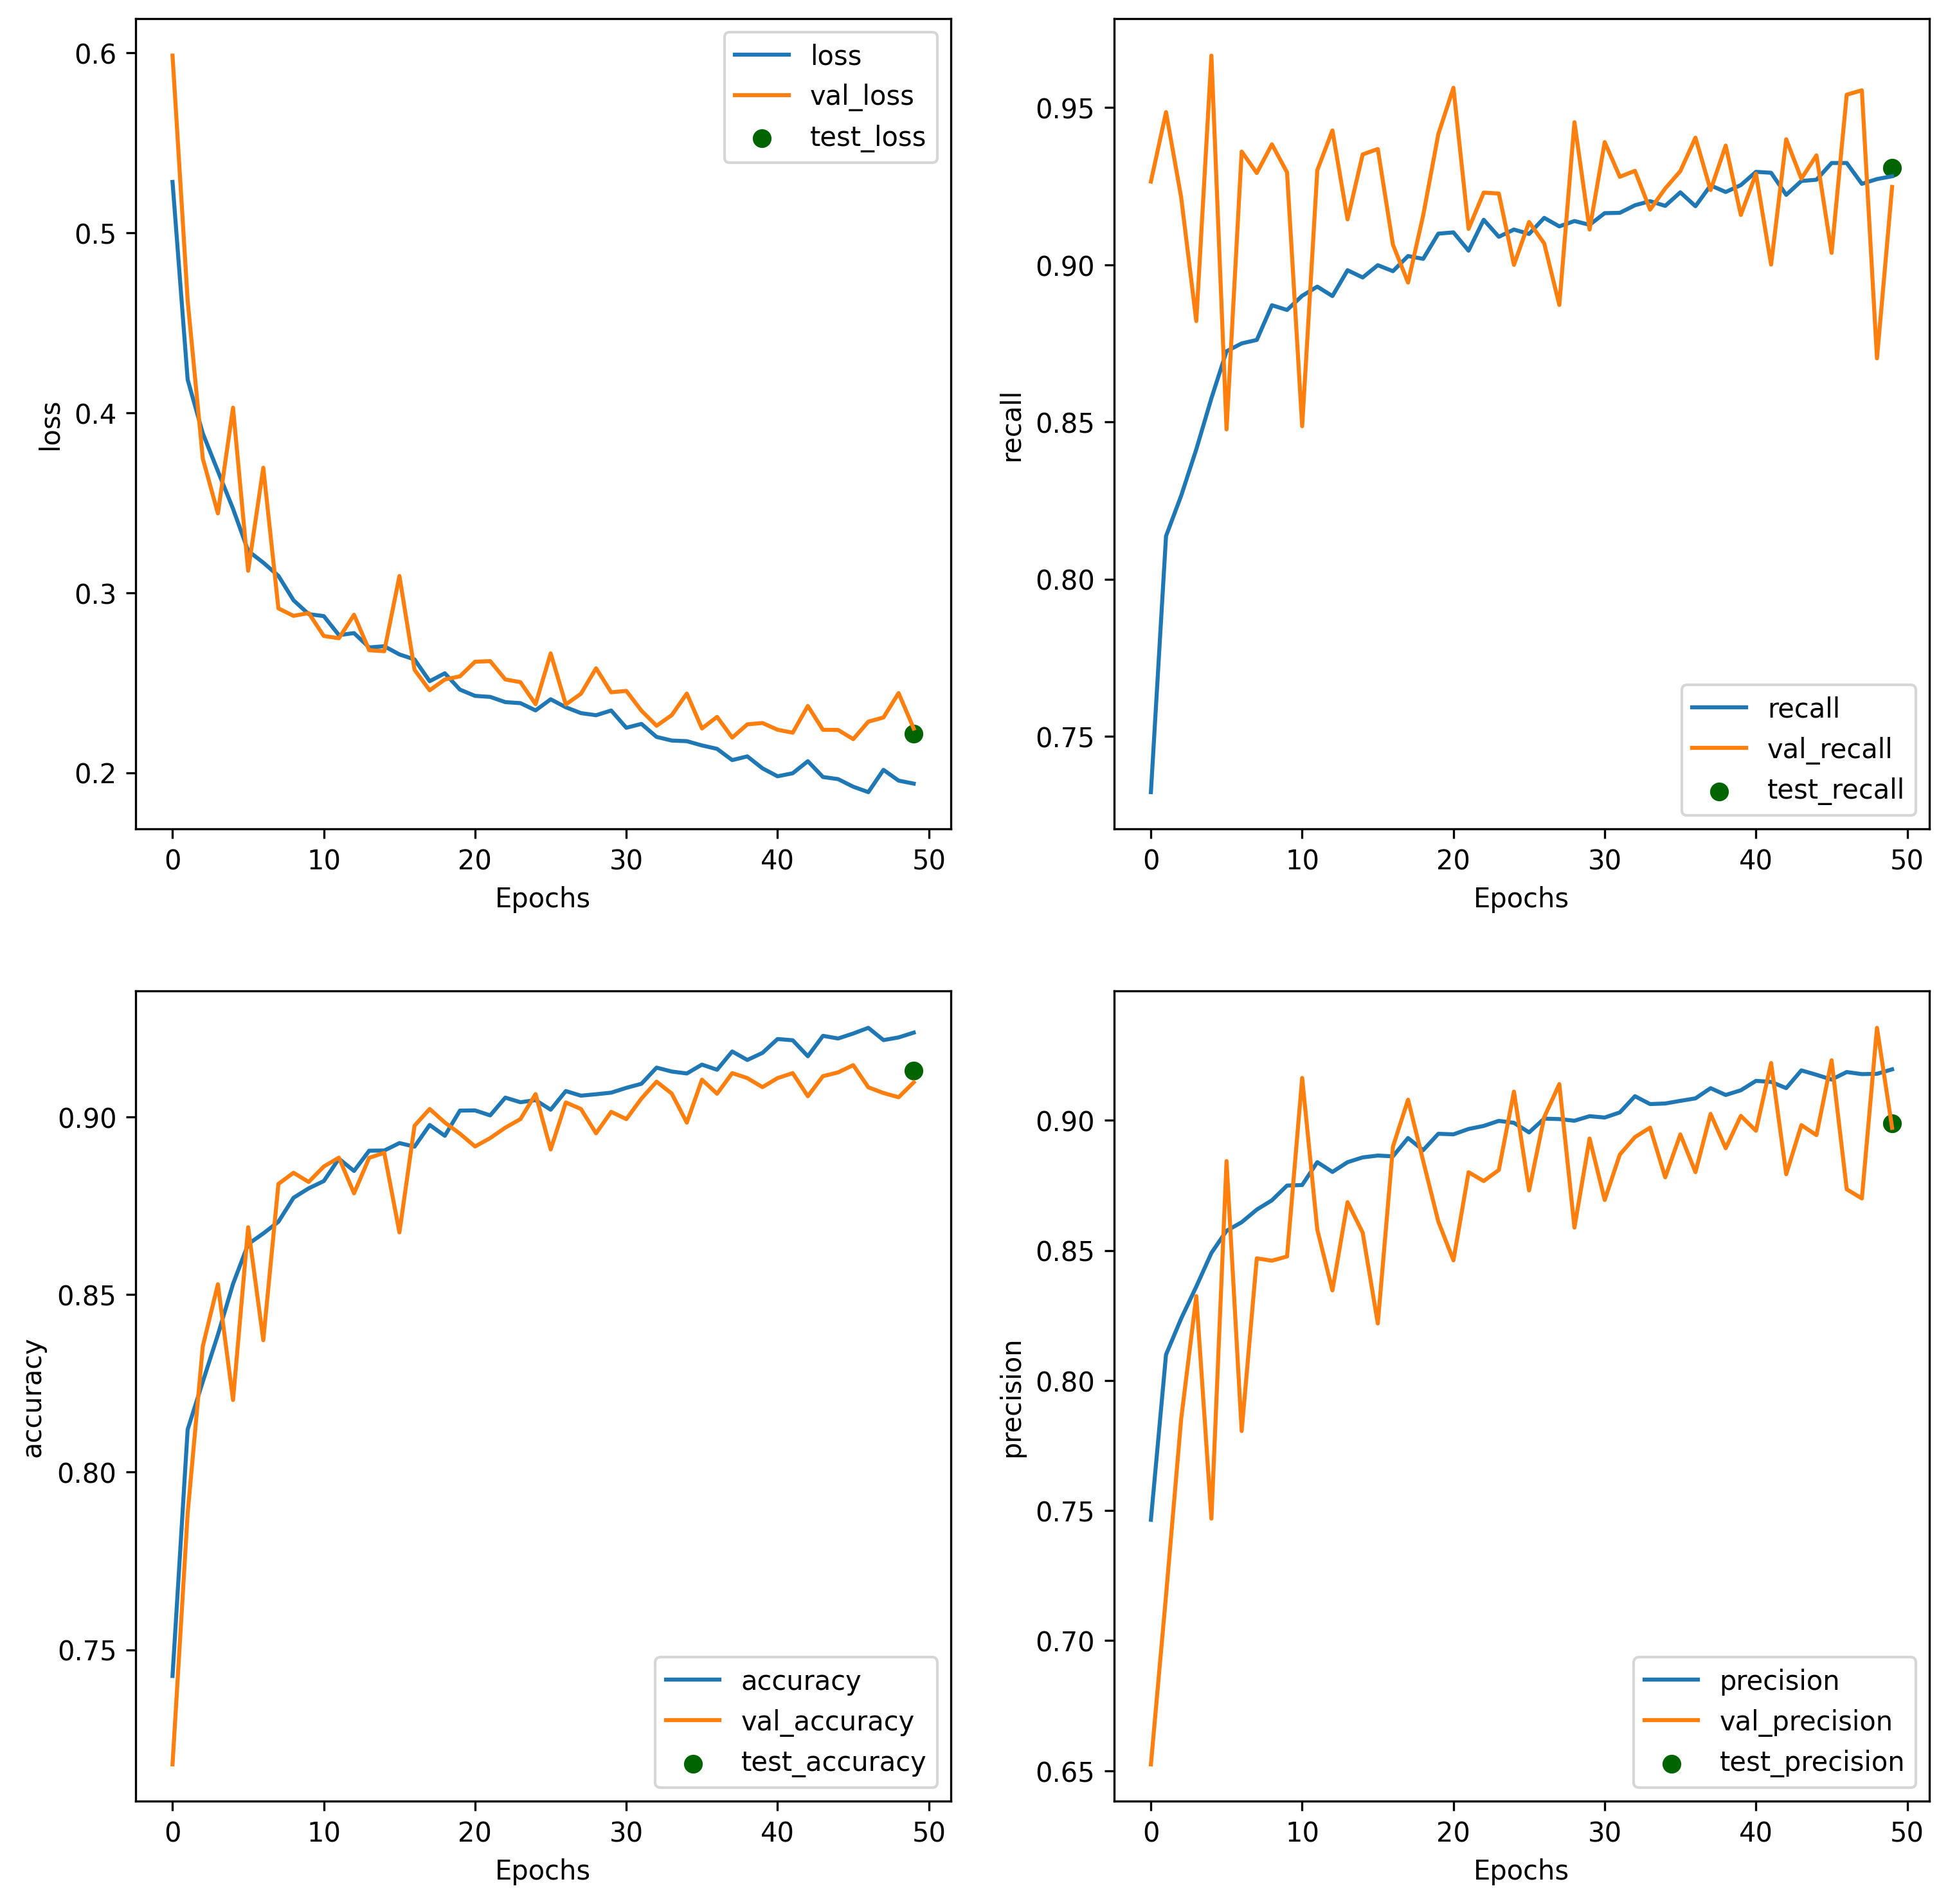

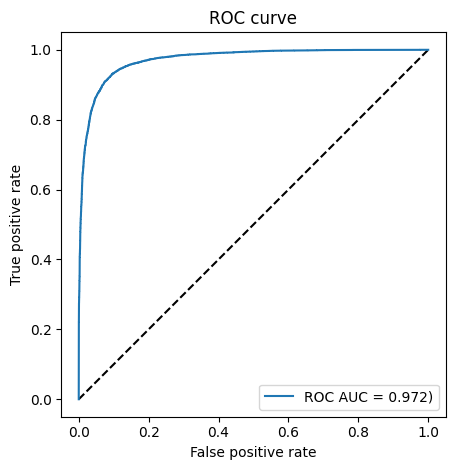

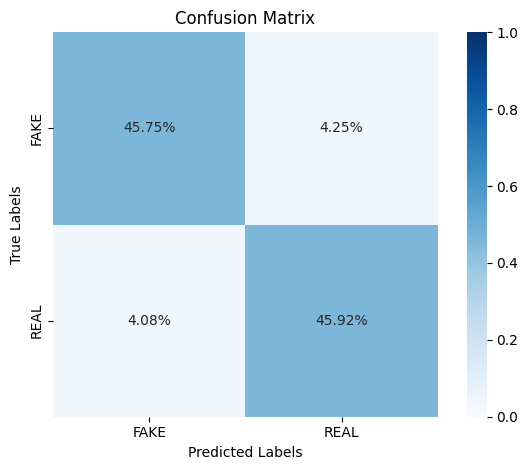

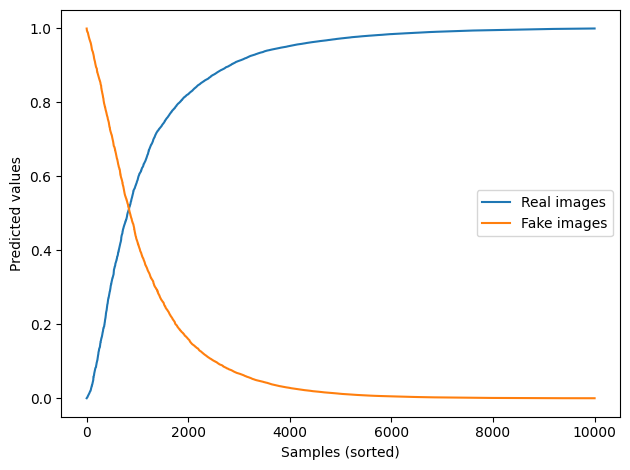

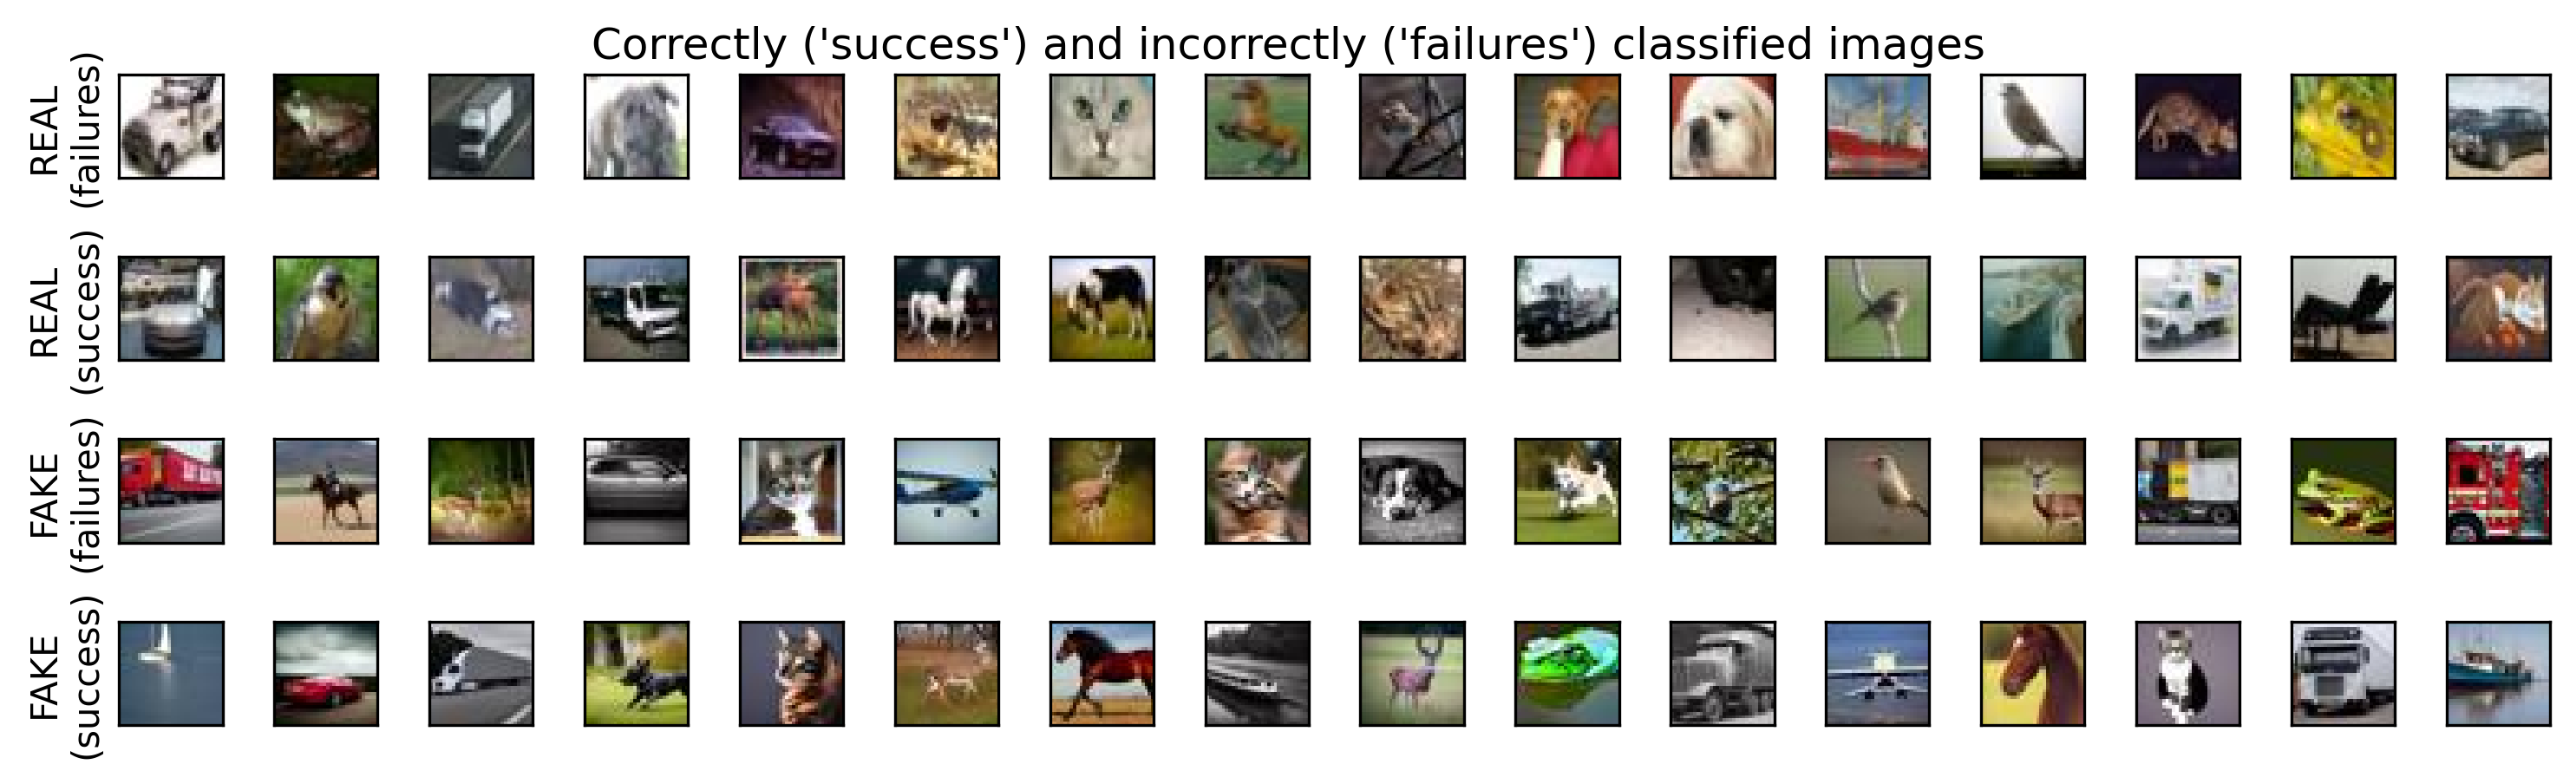

In [33]:
# Plot results
plot_metrics(history, test_loss, test_recall, test_accuracy, test_precision, number_of_epochs)
plot_roc_curve(labels, predicted_values)
plot_confusion_matrix(labels, predicted_classes, test_set_dataloader.class_names)
plot_predicted_values_per_class(predicted_values, labels)
plot_extreme_predictions(predicted_values, labels)

# Model 4 | U-Net Xception-style | 2.3M parameters | ROC AUX 0.972

In [34]:
"""
Credits: François Chollet
Adapted from: https://keras.io/examples/vision/oxford_pets_image_segmentation/
"""

def get_xception_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("silu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for num_filters in [64, 128, 256]:
        x = tf.keras.layers.Activation("silu")(x)        
        x = tf.keras.layers.SeparableConv2D(filters=num_filters, kernel_size=3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("silu")(x)        
        x = tf.keras.layers.SeparableConv2D(filters=num_filters, kernel_size=3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for num_filters in [256, 128, 64, 32]:
        x = tf.keras.layers.Activation("silu")(x)        
        x = tf.keras.layers.Conv2DTranspose(filters=num_filters, kernel_size=3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("silu")(x)    
        x = tf.keras.layers.Conv2DTranspose(filters=num_filters, kernel_size=3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = tf.keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=1, padding="same")(residual)
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = tf.keras.layers.Conv2D(filters=1, kernel_size=3, activation="silu", padding="same")(x)
    outputs = tf.keras.layers.BatchNormalization()(outputs)    
    outputs = keras.layers.Flatten()(outputs)
    outputs = tf.keras.layers.Dense(units=256, activation='sigmoid')(outputs)
    outputs = tf.keras.layers.Dropout(0.5)(outputs) # Random dropout to prevent overfitting    
    outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(outputs)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [35]:
# Build and compile the model, and show the summary
model = get_xception_model(img_size=(image_height, image_width), num_classes=2)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 16, 16,    │          0 │ activation[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 16, 16,    │      2,400 │ activation_1[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 16, 16,    │      4,736 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 64)  │      2,112 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 8, 8, 64)  │          0 │ max_pooling2d_5[… │
│                     │                   │            │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 8, 8, 64)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 8, 8, 128) │      8,896 │ activation_3[0][… │
│ (SeparableConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                 

 Total params: 2,321,062 (8.85 MB)

 Trainable params: 2,317,284 (8.84 MB)

 Non-trainable params: 3,778 (14.76 KB)

In [36]:
# Train the model
number_of_epochs = 50
history = model.fit(
    train_set_dataloader, validation_data=validation_set_dataloader, epochs=number_of_epochs, verbose=2)

Epoch 1/50
313/313 - 34s - 110ms/step - accuracy: 0.8468 - loss: 0.3552 - precision: 0.8432 - recall: 0.8509 - val_accuracy: 0.4979 - val_loss: 1.7881 - val_precision: 0.4979 - val_recall: 1.0000
Epoch 2/50
313/313 - 4s - 13ms/step - accuracy: 0.9037 - loss: 0.2433 - precision: 0.9031 - recall: 0.9037 - val_accuracy: 0.8928 - val_loss: 0.2582 - val_precision: 0.8974 - val_recall: 0.8859
Epoch 3/50
313/313 - 4s - 13ms/step - accuracy: 0.9221 - loss: 0.2014 - precision: 0.9233 - recall: 0.9201 - val_accuracy: 0.8974 - val_loss: 0.2864 - val_precision: 0.9404 - val_recall: 0.8476
Epoch 4/50
313/313 - 4s - 13ms/step - accuracy: 0.9336 - loss: 0.1730 - precision: 0.9329 - recall: 0.9338 - val_accuracy: 0.8210 - val_loss: 0.4696 - val_precision: 0.9775 - val_recall: 0.6555
Epoch 5/50
313/313 - 4s - 13ms/step - accuracy: 0.9398 - loss: 0.1533 - precision: 0.9380 - recall: 0.9415 - val_accuracy: 0.8597 - val_loss: 0.3904 - val_precision: 0.9670 - val_recall: 0.7437
Epoch 6/50
313/313 - 4s - 13

In [37]:
# Infer the model
evaluate_model(model, validation_set_dataloader, 'Validation')
test_loss, test_accuracy, test_precision, test_recall = evaluate_model(model, test_set_dataloader, 'Test')
predicted_values, predicted_classes, labels = get_predictions_and_labels(test_set_dataloader, model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9153 - loss: 0.4208 - precision: 0.8996 - recall: 0.9322
Dataset: Validation
Loss: 0.4380
Accuracy: 0.9133
Precision: 0.8979
Recall: 0.9317
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9165 - loss: 0.4247 - precision: 0.9003 - recall: 0.9354
Dataset: Test
Loss: 0.4421
Accuracy: 0.9128
Precision: 0.8963
Recall: 0.9335


W0000 00:00:1725545446.232310  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725545446.232935  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725545446.233521  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725545446.234100  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725545446.234690  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725545446.235270  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725545446.235857  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725545446.236466  128853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725545446.237056  128853 gp

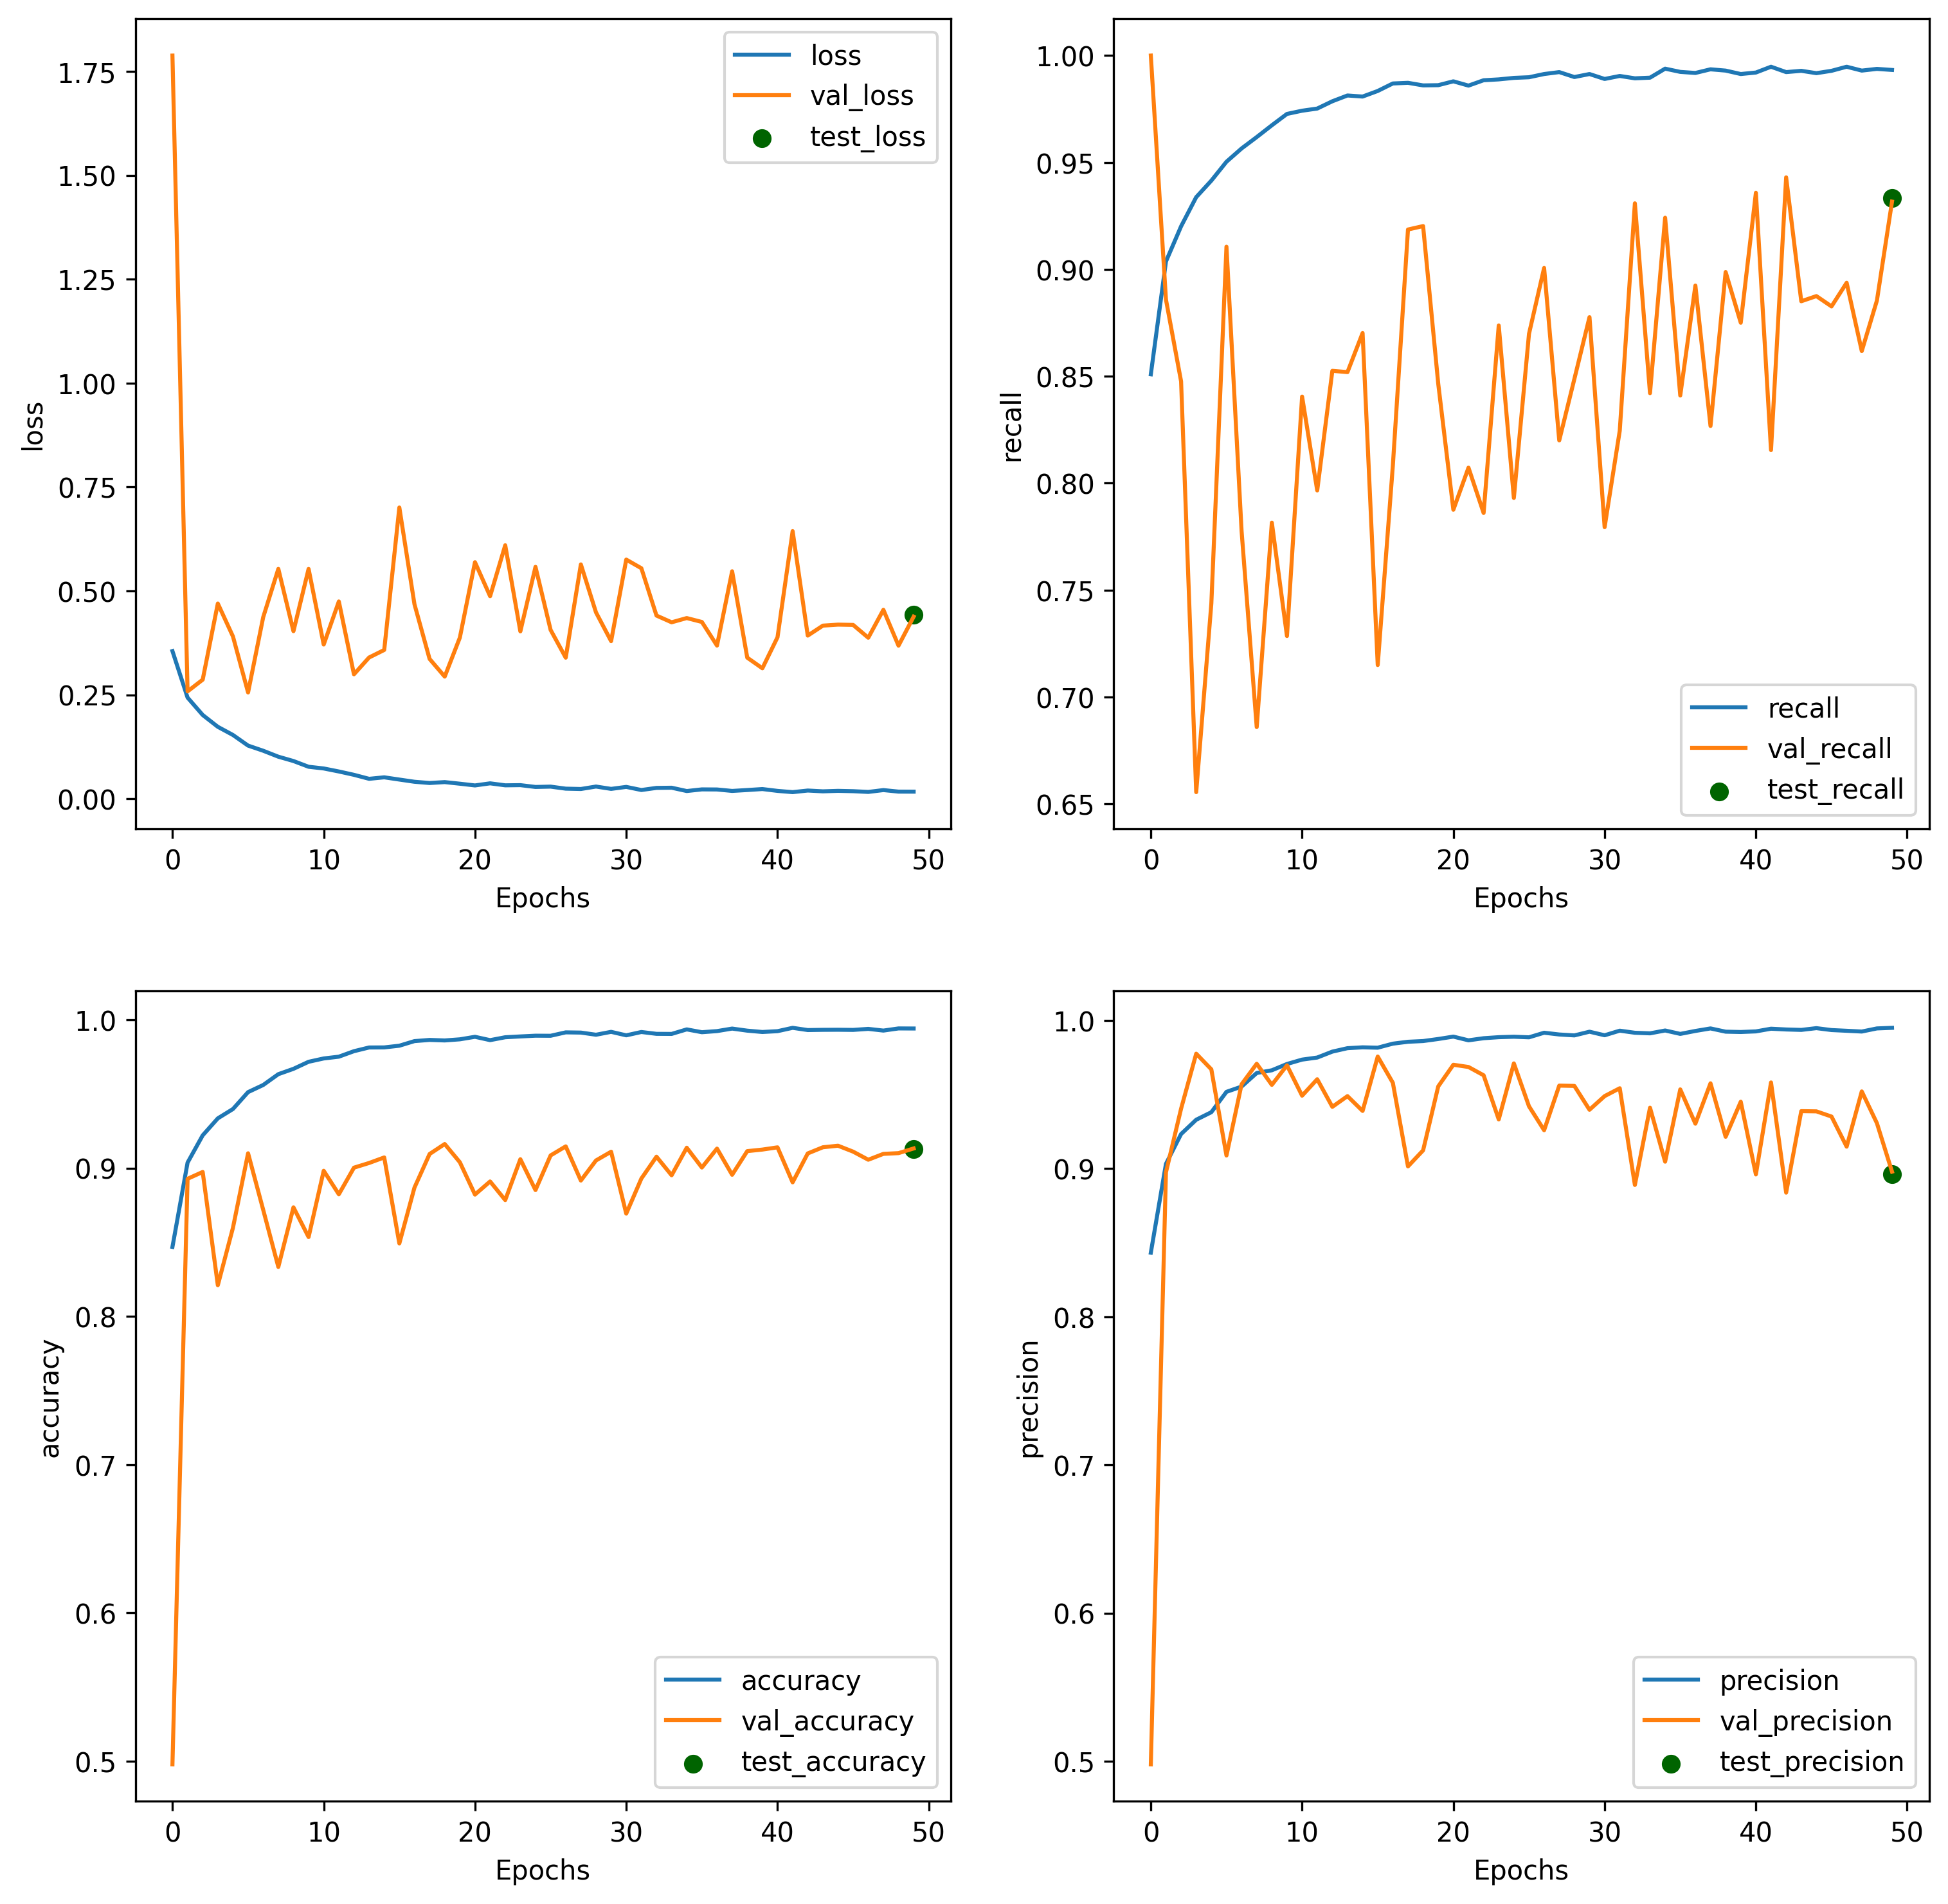

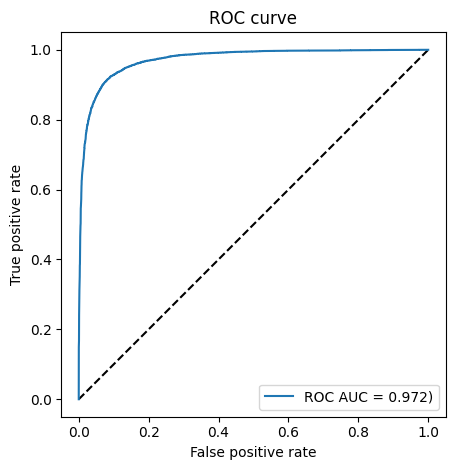

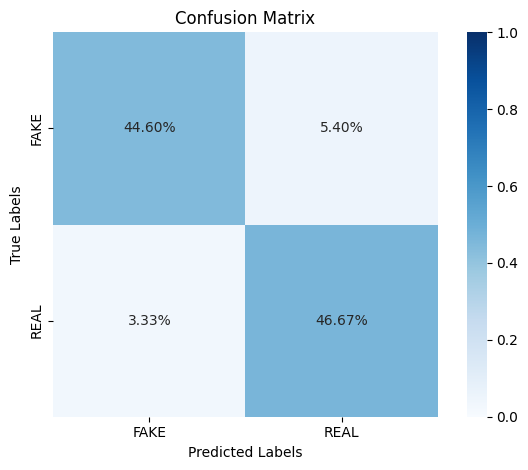

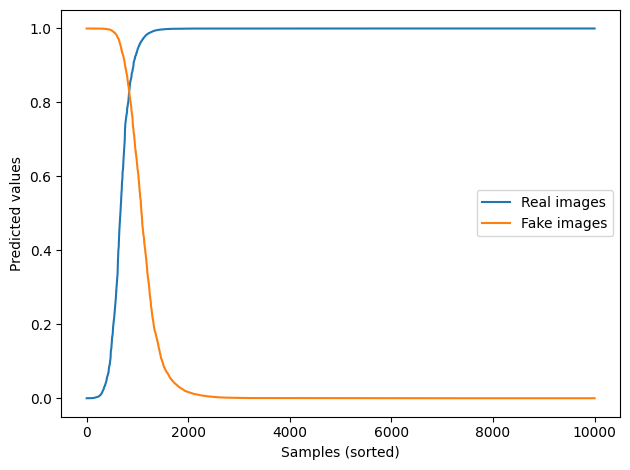

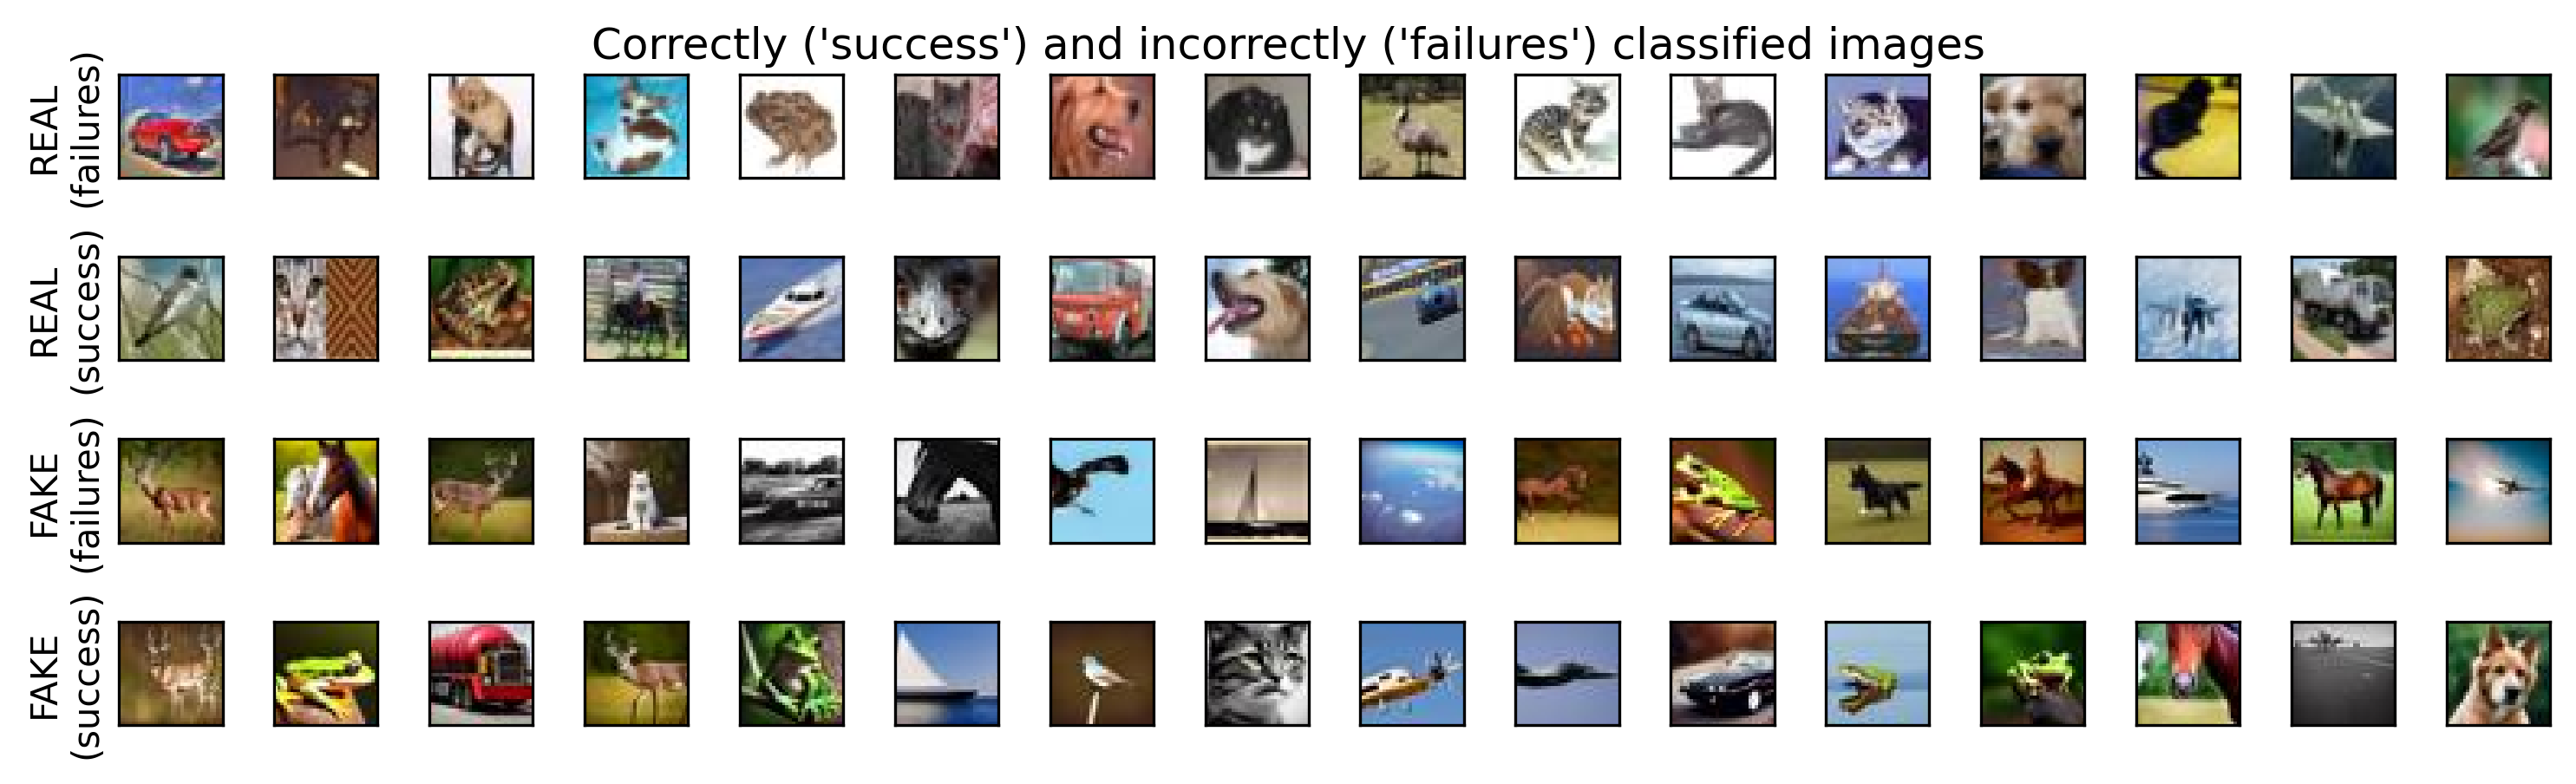

In [38]:
# Plot results
plot_metrics(history, test_loss, test_recall, test_accuracy, test_precision, number_of_epochs)
plot_roc_curve(labels, predicted_values)
plot_confusion_matrix(labels, predicted_classes, test_set_dataloader.class_names)
plot_predicted_values_per_class(predicted_values, labels)
plot_extreme_predictions(predicted_values, labels)

# Summary of key findings

# Potential flaws of the current analysis and possible future improvements